#  Post-COVID Charity Segmentation

## 1. Task Scenario

Background:
COVID-19 disrupted the charitable sector. The client needs a new, data-driven segmentation framework that reflects resilience, adaptability, and impact, not just size.

Objective:
1. Write a high-level recommendation for post-COVID segmentation.
2. Support your recommendation with 3 major data insights.
3. Build an ML model to segment charities into meaningful groups.

### No need to use markdown (.md) formatting — plain text is fine

## 2. Imports


In [4]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns

## 3. Load and Explore the Dataset


In [6]:
df = pd.read_csv('charity_record_2018-2022.csv')

## 4. Data Preparation


### Data health check and cleansing

In [9]:
df.columns.tolist()     
df.head() 
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38354 entries, 0 to 38353
Data columns (total 46 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   regno_index       38354 non-null  int64  
 1   orgtype           38354 non-null  object 
 2   income            38354 non-null  float64
 3   expend            38354 non-null  float64
 4   financial_year    38354 non-null  object 
 5   fyend             38354 non-null  object 
 6   aob_classified    38354 non-null  object 
 7   postcode          38255 non-null  object 
 8   geog_LA           38206 non-null  object 
 9   inc_leg           38354 non-null  float64
 10  inc_end           38354 non-null  int64  
 11  inc_vol           38354 non-null  float64
 12  inc_fr            38354 non-null  float64
 13  inc_char          38354 non-null  float64
 14  inc_invest        38354 non-null  float64
 15  inc_other         38354 non-null  int64  
 16  inc_total         38354 non-null  float6

### Standardise column names and drop duplicates:

In [11]:
# whitespace,lowercase, and replace dots and spaces wuth _

df.columns = (
    df.columns
      .str.strip()
      .str.lower() 
      .str.replace(r"[ \.]+", "_", regex=True) 
)

In [12]:
# drop duplicated instances

df = df.drop_duplicates()

### Missing values check:

Checked for missing values and changed them to 'Unknown'

In [14]:
missing = df.isna().sum()
print(missing[missing > 0]) 

postcode     99
geog_la     148
dtype: int64


In [15]:
# change NaN values with Unknown
for col in ['postcode', 'geog_la']:
    df[col] = df[col].fillna('Unknown')
    df[col] = df[col].astype('category')

In [16]:
print(df[['postcode', 'geog_la']].isna().sum())
print(df['postcode'].cat.categories)
print(df['geog_la'].cat.categories)

postcode    0
geog_la     0
dtype: int64
Index(['AB423DQ', 'AL1 1HE', 'AL1 1LA', 'AL1 1PD', 'AL1 2NW', 'AL1 3JW',
       'AL1 3SJ', 'AL1 3UB', 'AL1 5EN', 'AL1 5UG',
       ...
       'YO422TH', 'YO606PR', 'YO612RW', 'YO624EN', 'YO624ER', 'YO7 3BZ',
       'YO7 4EN', 'YO7 4NJ', 'YO8 3TZ', 'YO8 8NL'],
      dtype='object', length=8743)
Index(['E06000001', 'E06000002', 'E06000003', 'E06000004', 'E06000005',
       'E06000006', 'E06000007', 'E06000008', 'E06000009', 'E06000010',
       ...
       'W06000014', 'W06000015', 'W06000016', 'W06000018', 'W06000019',
       'W06000020', 'W06000021', 'W06000022', 'W06000023', 'W06000024'],
      dtype='object', length=364)


### Date parsing
Added a fystart based on column 'fyend' and changed datatypes to date


In [18]:
df['fyend'] = pd.to_datetime(df['fyend'], format='%d/%m/%Y')

In [19]:
df['fystart'] = (
    df['fyend']
      - pd.DateOffset(years=1)
      + pd.DateOffset(days=1)
)

In [20]:
df[['fyend','fystart']].head()

,fyend,fystart
0,2019-03-31,2018-04-01
1,2020-03-31,2019-04-01
2,2021-03-31,2020-04-01
3,2022-03-31,2021-04-01
4,2019-12-31,2019-01-01


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38354 entries, 0 to 38353
Data columns (total 47 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   regno_index       38354 non-null  int64         
 1   orgtype           38354 non-null  object        
 2   income            38354 non-null  float64       
 3   expend            38354 non-null  float64       
 4   financial_year    38354 non-null  object        
 5   fyend             38354 non-null  datetime64[ns]
 6   aob_classified    38354 non-null  object        
 7   postcode          38354 non-null  category      
 8   geog_la           38354 non-null  category      
 9   inc_leg           38354 non-null  float64       
 10  inc_end           38354 non-null  int64         
 11  inc_vol           38354 non-null  float64       
 12  inc_fr            38354 non-null  float64       
 13  inc_char          38354 non-null  float64       
 14  inc_invest        3835

In [22]:
pd.set_option('display.max_columns', None)
df.head()

,regno_index,orgtype,income,expend,financial_year,fyend,aob_classified,postcode,geog_la,inc_leg,inc_end,inc_vol,inc_fr,inc_char,inc_invest,inc_other,inc_total,invest_gain,asset_gain,pension_gain,exp_invest,exp_grant,exp_charble,exp_fr,exp_gov,exp_other,exp_total,exp_support,exp_dep,reserves,asset_close,fixed_assets,invest_assets,cash_assets,current_assets,credit_1,credit_long,pension_assets,total_assets,funds_end,funds_restrict,funds_unrestrict,funds_total,employees,volunteers,icnpo_category,fystart
0,1,R,1254612.0,1340317.0,2018-19,2019-03-31,National,RG109XR,E06000041,5317.0,0,612079.0,0.0,627720.0,218.0,0,1254612.0,0.0,0.0,0.0,0.0,0.0,1292447.0,47870.0,3254.0,0.0,1340317.0,174140.0,53121.0,0,703952.0,0.0,0.0,89091.0,224455.0,43058.0,0.0,0,0,0,44891.0,840458.0,885349.0,29.0,0,Religious congregations and associations,2018-04-01
1,1,R,1240406.0,1315502.0,2019-20,2020-03-31,National,RG109XR,E06000041,600.0,0,592537.0,0.0,628019.0,53.0,0,1240406.0,0.0,0.0,0.0,0.0,0.0,1256463.0,59039.0,3372.0,0.0,1315502.0,181996.0,45834.0,0,658118.0,0.0,0.0,89693.0,199391.0,47256.0,0.0,0,0,0,35098.0,775155.0,810253.0,33.0,0,Religious congregations and associations,2019-04-01
2,1,R,1399562.0,1330114.0,2020-21,2021-03-31,National,RG109XR,E06000041,0.0,0,696774.0,0.0,681718.0,175.0,0,1399562.0,0.0,0.0,0.0,0.0,0.0,1235361.0,94753.0,3372.0,0.0,1330114.0,190972.0,44672.0,0,668625.0,0.0,0.0,257367.0,379404.0,64328.0,104000.0,0,0,0,40454.0,839247.0,879701.0,34.0,0,Religious congregations and associations,2020-04-01
3,1,R,1382841.0,1400805.0,2021-22,2022-03-31,National,RG109XR,E06000041,3804.0,0,788741.0,0.0,559443.0,4.0,0,1382841.0,0.0,0.0,0.0,0.0,0.0,1338301.0,62504.0,3623.0,0.0,1400805.0,198447.0,49577.0,0,730506.0,0.0,0.0,241234.0,281125.0,69894.0,80000.0,0,0,0,71887.0,789850.0,861737.0,37.0,0,Religious congregations and associations,2021-04-01
4,3,R,523687.0,520087.0,2019-20,2019-12-31,National and overseas,HA7 1JS,E09000015,0.0,0,523687.0,0.0,0.0,0.0,0,523687.0,0.0,0.0,0.0,0.0,0.0,38413.0,424422.0,0.0,57252.0,520087.0,0.0,5704.0,0,40298.0,0.0,0.0,1127280.0,1241412.0,12176.0,0.0,0,0,0,1027665.0,241869.0,1269534.0,6.0,0,Religious congregations and associations,2019-01-01


### Convert data types

Changed dates to datetime; changed numerical values to float & integer; changed categorical columns to category

In [24]:
# Convert date columns

date_cols = ['fyend', 'fystart']
for col in date_cols:
        df[col] = pd.to_datetime(df[col], dayfirst=True, errors='raise')
print(df[date_cols].dtypes)

fyend      datetime64[ns]
fystart    datetime64[ns]
dtype: object


In [25]:
# Convert numerical columns to float and integer

num_cols = [
    'income','expend',
    'inc_leg','inc_end','inc_vol','inc_fr','inc_char','inc_invest','inc_other','inc_total',
    'invest_gain','asset_gain','pension_gain',
    'exp_invest','exp_grant','exp_charble','exp_fr','exp_gov','exp_other','exp_total','exp_support','exp_dep',
    'reserves',
    'asset_close','fixed_assets','invest_assets','cash_assets','current_assets',
    'credit_1','credit_long','pension_assets','total_assets',
    'funds_end','funds_restrict','funds_unrestrict','funds_total',
    'employees','volunteers'
]


missing = [c for c in num_cols if c not in df.columns]
print("These expected cols are NOT in df:", missing)


present = [c for c in num_cols if c in df.columns]
for col in present:
    df[col] = (
        df[col]
          .astype(str)
          .str.replace(r'[\,\£\$\€]', '', regex=True)
    )
    df[col] = pd.to_numeric(df[col], errors='coerce')

print(df[present].dtypes)

These expected cols are NOT in df: []
income              float64
expend              float64
inc_leg             float64
inc_end               int64
inc_vol             float64
inc_fr              float64
inc_char            float64
inc_invest          float64
inc_other             int64
inc_total           float64
invest_gain         float64
asset_gain          float64
pension_gain        float64
exp_invest          float64
exp_grant           float64
exp_charble         float64
exp_fr              float64
exp_gov             float64
exp_other           float64
exp_total           float64
exp_support         float64
exp_dep             float64
reserves              int64
asset_close         float64
fixed_assets        float64
invest_assets       float64
cash_assets         float64
current_assets      float64
credit_1            float64
credit_long         float64
pension_assets        int64
total_assets          int64
funds_end             int64
funds_restrict      float64
funds_unre

In [26]:
# Convert categorical columns

cat_cols = [
    'regno_index','orgtype','aob_classified','postcode','geog_la','icnpo_category'
]
for col in cat_cols:
    df[col] = df[col].astype('category')

print(df.dtypes[['financial_year','fyend','fystart'] + num_cols[:3] + cat_cols[:3]])
print(df.head())

financial_year            object
fyend             datetime64[ns]
fystart           datetime64[ns]
income                   float64
expend                   float64
inc_leg                  float64
regno_index             category
orgtype                 category
aob_classified          category
dtype: object
  regno_index orgtype     income     expend financial_year      fyend  \
0           1       R  1254612.0  1340317.0        2018-19 2019-03-31   
1           1       R  1240406.0  1315502.0        2019-20 2020-03-31   
2           1       R  1399562.0  1330114.0        2020-21 2021-03-31   
3           1       R  1382841.0  1400805.0        2021-22 2022-03-31   
4           3       R   523687.0   520087.0        2019-20 2019-12-31   

          aob_classified postcode    geog_la  inc_leg  inc_end   inc_vol  \
0               National  RG109XR  E06000041   5317.0        0  612079.0   
1               National  RG109XR  E06000041    600.0        0  592537.0   
2               Nation

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38354 entries, 0 to 38353
Data columns (total 47 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   regno_index       38354 non-null  category      
 1   orgtype           38354 non-null  category      
 2   income            38354 non-null  float64       
 3   expend            38354 non-null  float64       
 4   financial_year    38354 non-null  object        
 5   fyend             38354 non-null  datetime64[ns]
 6   aob_classified    38354 non-null  category      
 7   postcode          38354 non-null  category      
 8   geog_la           38354 non-null  category      
 9   inc_leg           38354 non-null  float64       
 10  inc_end           38354 non-null  int64         
 11  inc_vol           38354 non-null  float64       
 12  inc_fr            38354 non-null  float64       
 13  inc_char          38354 non-null  float64       
 14  inc_invest        3835

### Clean categorical data

In [29]:
# Strip and unify orgtype

df['orgtype'] = (
    df['orgtype']
      .str.strip()
      .str.title()        
      .astype('category')
)

In [30]:
# Clean icnpo 

df['icnpo_category'] = (
    df['icnpo_category']
      .str.strip()
      .str.upper()    
      .astype('category')
)

In [31]:
# Top 50 postcodes + Unknown + grouping others 

raw_top = df['postcode'].value_counts().nlargest(50).index.tolist()
top_postcodes = [pc for pc in raw_top if pc not in ('Unknown','Other')]

mask_top     = df['postcode'].isin(top_postcodes)
mask_unknown = df['postcode'] == 'Unknown'

df['postcode_grouped'] = np.where(
    mask_top,
    df['postcode'],           
    np.where(mask_unknown, 
             'Unknown',       
             'Other')         
)

cat_list = top_postcodes + ['Unknown','Other']
df['postcode_grouped'] = pd.Categorical(df['postcode_grouped'], 
                                        categories=cat_list)

df['postcode_grouped'] = df['postcode_grouped'].cat.remove_unused_categories()

print(df['postcode_grouped'].cat.categories)
print(df['postcode_grouped'].value_counts())

Index(['SE1 4YR', 'WC2R1LA', 'NW110PU', 'SE115RR', 'SW1V1AP', 'EC4R1BE',
       'E2  9DA', 'EC2P2EJ', 'WC2B5AZ', 'EC4M7AN', 'N1  6AH', 'WC2A3PE',
       'WC1N1AZ', 'EC1V2NX', 'SW1Y5AH', 'GL8 8SQ', 'E1  8AN', 'SW1P4QP',
       'SE1 7TP', 'EC1V2PT', 'LE113QF', 'WC1H9NA', 'EC4A3AQ', 'CF105AL',
       'BN1 3XG', 'WC2A2JR', 'EC1A7BL', 'SW1W0DH', 'BR1 3QG', 'N16 7EJ',
       'E8  3DL', 'NW4 3LP', 'EC1Y8RT', 'SW1H9JJ', 'N16 6AG', 'N16 6QT',
       'WC2A3LH', 'EC2R8AB', 'W1W 5DR', 'E5  9AB', 'SP4 8QT', 'SE115DP',
       'EC4R1AG', 'N1  9RL', 'E1  7LS', 'W10 5XL', 'N7  6PA', 'N7  8QJ',
       'N16 6HD', 'Unknown', 'Other'],
      dtype='object')
postcode_grouped
Other      36780
Unknown       99
SE1 4YR       93
WC2R1LA       78
NW110PU       74
SE115RR       66
SW1V1AP       52
EC4R1BE       50
E2  9DA       44
EC2P2EJ       43
WC2B5AZ       41
EC4M7AN       40
N1  6AH       39
WC2A3PE       38
WC1N1AZ       34
EC1V2NX       32
SW1Y5AH       30
GL8 8SQ       28
E1  8AN       27
SW1P4QP       2

### Feature Engineering & Validation

In [33]:
print(df.columns.tolist())

['regno_index', 'orgtype', 'income', 'expend', 'financial_year', 'fyend', 'aob_classified', 'postcode', 'geog_la', 'inc_leg', 'inc_end', 'inc_vol', 'inc_fr', 'inc_char', 'inc_invest', 'inc_other', 'inc_total', 'invest_gain', 'asset_gain', 'pension_gain', 'exp_invest', 'exp_grant', 'exp_charble', 'exp_fr', 'exp_gov', 'exp_other', 'exp_total', 'exp_support', 'exp_dep', 'reserves', 'asset_close', 'fixed_assets', 'invest_assets', 'cash_assets', 'current_assets', 'credit_1', 'credit_long', 'pension_assets', 'total_assets', 'funds_end', 'funds_restrict', 'funds_unrestrict', 'funds_total', 'employees', 'volunteers', 'icnpo_category', 'fystart', 'postcode_grouped']


In [34]:
# Spent vs awarded ratio

df['spent_ratio'] = df['exp_total'] / df['inc_total'].replace({0: np.nan})
df['income_to_reserve'] = df['inc_total'] / df['reserves'].replace({0: np.nan})

In [35]:
# Year‐on‐year changes via group‐differences in assets

df = df.sort_values(['regno_index', 'fystart'])


df['net_asset_change'] = (
    df
      .groupby('regno_index')['asset_close']
      .diff()
)


df['net_fund_change'] = (
    df
      .groupby('regno_index')['funds_total']
      .diff()
)

print(df.loc[:, ['regno_index','financial_year','asset_close','net_asset_change',
                 'funds_total','net_fund_change']].head(10))

  regno_index financial_year  asset_close  net_asset_change  funds_total  \
0           1        2018-19     703952.0               NaN     885349.0   
1           1        2019-20     658118.0          -45834.0     810253.0   
2           1        2020-21     668625.0           10507.0     879701.0   
3           1        2021-22     730506.0           61881.0     861737.0   
4           3        2019-20      40298.0               NaN    1269534.0   
5           3        2020-21      63065.0           22767.0    1303950.0   
6           3        2021-22      29562.0          -33503.0    1240425.0   
7           4        2018-19    4429240.0               NaN    4821739.0   
8           4        2019-20    4602923.0          173683.0    5127862.0   
9           4        2020-21    4652864.0           49941.0    5326614.0   

   net_fund_change  
0              NaN  
1         -75096.0  
2          69448.0  
3         -17964.0  
4              NaN  
5          34416.0  
6         -63525

In [36]:
#   Fiscal‐year start year & quarter

df['fy_start_year']  = df['fystart'].dt.year
df['fy_start_quarter'] = df['fystart'].dt.to_period('Q')

In [37]:
#   Expenses exceed income?

df['exp_gt_inc'] = (df['exp_total'] > df['inc_total']).astype(int)

In [38]:
#   Charitable spend > charitable income?

df['char_exp_gt_char_inc'] = (df['exp_charble'] > df['inc_char']).astype(int)

In [39]:
#   Z-scores for total income & expenditure

df['inc_z'] = zscore(df['inc_total'].fillna(0))
df['exp_z'] = zscore(df['exp_total'].fillna(0))

In [40]:
#   Mark outliers beyond ±3σ

df['inc_outlier'] = (df['inc_z'].abs() > 3).astype(int)
df['exp_outlier'] = (df['exp_z'].abs() > 3).astype(int)

In [41]:
print("Rows with exp > inc:", df['exp_gt_inc'].sum())
print("Rows where char. spend > char. income:", df['char_exp_gt_char_inc'].sum())
print("Income outliers (±3σ):", df['inc_outlier'].sum())
print("Expense outliers (±3σ):", df['exp_outlier'].sum())

Rows with exp > inc: 13586
Rows where char. spend > char. income: 30438
Income outliers (±3σ): 317
Expense outliers (±3σ): 292


In [42]:
print(df.loc[df['exp_gt_inc']==1, ['regno_index','inc_total','exp_total']].head())
print(df.loc[df['inc_outlier']==1, ['regno_index','inc_total','inc_z']].head())

   regno_index  inc_total  exp_total
0            1  1254612.0  1340317.0
1            1  1240406.0  1315502.0
3            1  1382841.0  1400805.0
6            3   500243.0   563768.0
11           7   579974.0   823275.0
     regno_index    inc_total     inc_z
353          140  184012535.0  5.569724
354          140  236679000.0  7.225053
355          140  219531000.0  6.686084
356          140  176787000.0  5.342622
1223         438  264355000.0  8.094922


### EDA

In [44]:
# Summary stats

summary = df.describe().T
print(summary)

                        count                           mean  \
income                38354.0                 6804511.993547   
expend                38354.0                 6583199.962742   
fyend                   38354  2020-07-11 16:48:20.724826368   
inc_leg               38354.0                  280713.104983   
inc_end               38354.0                   21411.785733   
inc_vol               38354.0                 2035993.365542   
inc_fr                38354.0                  605877.073956   
inc_char              38354.0                  3653835.36167   
inc_invest            38354.0                  299160.471607   
inc_other             38354.0                   15457.877875   
inc_total             38354.0                 6804511.993547   
invest_gain           38354.0                   817984.89902   
asset_gain            38354.0                   61926.009008   
pension_gain          38354.0                    17500.23871   
exp_invest            38354.0           

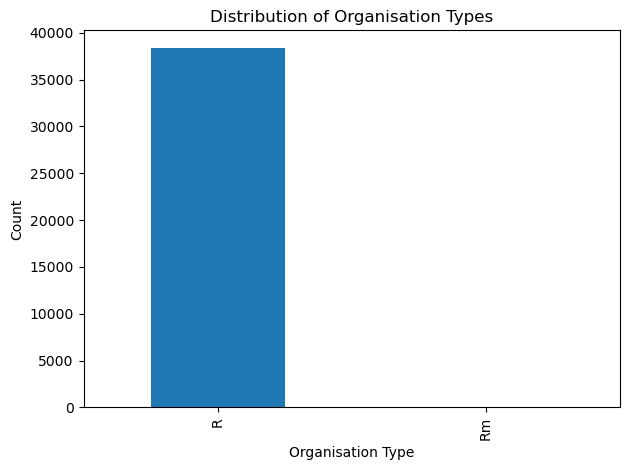

In [45]:
# org type distribution

import matplotlib.pyplot as plt

plt.figure()
df['orgtype'].value_counts().plot(kind='bar')
plt.title("Distribution of Organisation Types")
plt.xlabel("Organisation Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

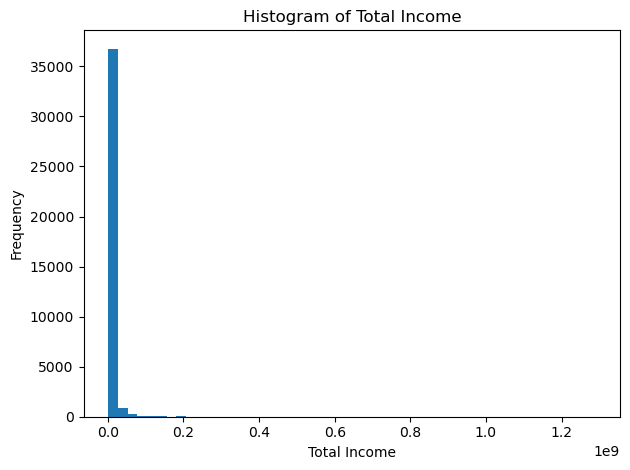

In [46]:
# total income

plt.figure()
plt.hist(df['inc_total'].dropna(), bins=50)
plt.title("Histogram of Total Income")
plt.xlabel("Total Income")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Heavily skewed on the right - few charities that have enormous incomes and most clustered near 0

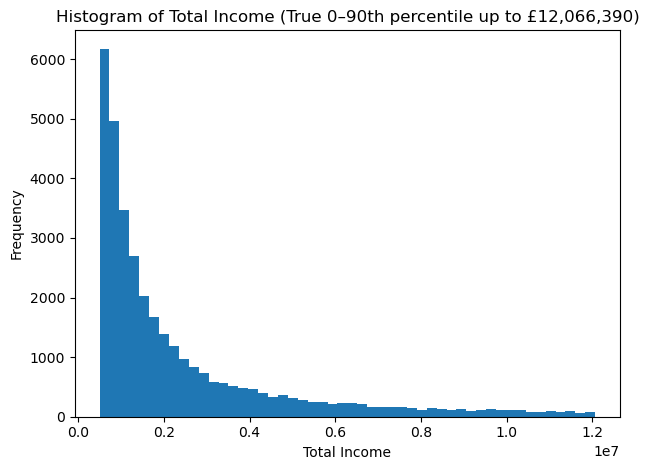

In [48]:
# Dropped the 10% of charities with huge income for a better view of the small and medium charities

p90 = df['inc_total'].quantile(0.90)

plt.figure()
plt.hist(
    df.loc[df['inc_total'] <= p90, 'inc_total'], 
    bins=50
)
plt.title(f"Histogram of Total Income (True 0–90th percentile up to £{p90:,.0f})")
plt.xlabel("Total Income")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Most charities have a relatively low annual income as they cluster under 2 million pounds

In [50]:
# Quantify the above
pd.set_option('display.float_format', '{:,.2f}'.format)

percentiles = [0.25, 0.50, 0.75, 0.90, 0.99]
desc = df['inc_total'].describe(percentiles=percentiles)

keys = ['count','mean','std','min'] + [f"{int(p*100)}%" for p in percentiles] + ['max']

stats = desc.loc[keys]
print(stats)

print("\nSkewness:", df['inc_total'].skew())

count          38,354.00
mean        6,804,511.99
std        31,816,718.20
min           500,002.00
25%           885,006.50
50%         1,635,650.00
75%         4,213,485.50
90%        12,066,390.20
99%        84,966,980.00
max     1,290,104,000.00
Name: inc_total, dtype: float64

Skewness: 21.133524228766063


A small number of very large charities are increasing the mean far above the median. Most charities are in betweeb £0.5 - £4 M; with a huge difference from £12 M to £85 M and then over £1 B 

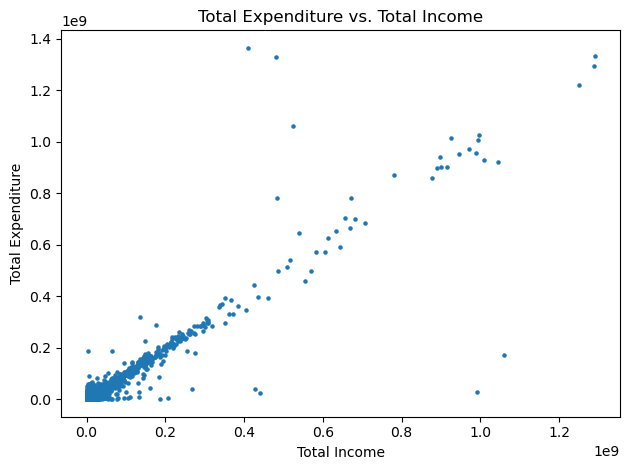

In [52]:
# expenses vs income

plt.figure()
plt.scatter(df['inc_total'], df['exp_total'], s=5)
plt.title("Total Expenditure vs. Total Income")
plt.xlabel("Total Income")
plt.ylabel("Total Expenditure")
plt.tight_layout()
plt.show()

There is a rough linear relationship betweeb the income and expenditure, with most charities tending to spend what they bring in. When it comes to the extremes, a handful spend less than their income, and very few, if any spend more than they earn. 

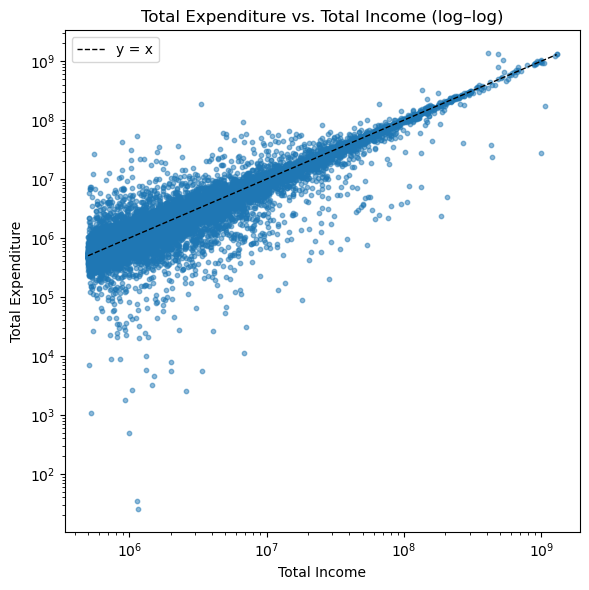

In [54]:
# Check to see the under and overspend

import matplotlib.pyplot as plt
import numpy as np

x = df['inc_total']
y = df['exp_total']

plt.figure(figsize=(6,6))
plt.scatter(x, y, s=10, alpha=0.5)
plt.xscale('log')
plt.yscale('log')

lims = [
    max(x.min(), y.min()),  # lower bound
    min(x.max(), y.max())   # upper bound
]
plt.plot(lims, lims, 'k--', linewidth=1, label='y = x')

plt.title("Total Expenditure vs. Total Income (log–log)")
plt.xlabel("Total Income")
plt.ylabel("Total Expenditure")
plt.legend()
plt.tight_layout()
plt.show()


This reinforces the above. The relationship is almost linear, with small charities spending less than they earn. This cvan be indicative of building reserves. Larger charities tend to cluster around the line meaning that they spend around the amount of income, and medium charities tend to go under or overbudget. There are a handful of charities that spend way over the income - they could either be using reserves.

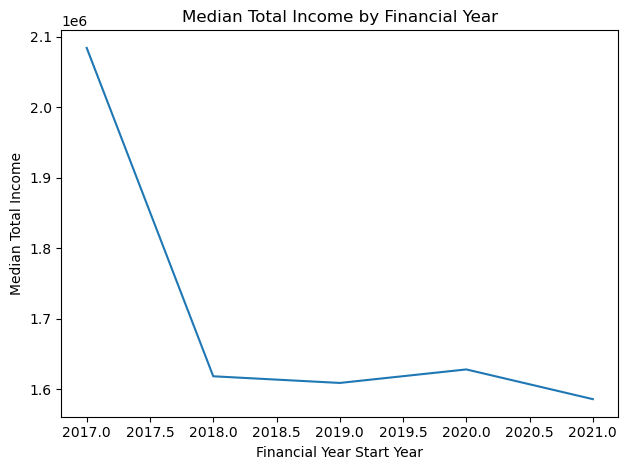

In [56]:
# median income by financial year

median_income = df.groupby('fy_start_year')['inc_total'].median()

plt.figure()
median_income.plot()
plt.title("Median Total Income by Financial Year")
plt.xlabel("Financial Year Start Year")
plt.ylabel("Median Total Income")
plt.tight_layout()
plt.show()


There is a sharp drop after 2017-2019, with the median hovering aroung 1.6 M. There is a small uptick in 2020-21 then it drops bwlow 1.6 M, still with persistent right skewness. Around half of all charities bring in aroun 1.6 M anuy given year. The subsequent bump then drop can be attributed to the pandemic. The hike perhaps due to consolidation or one-off grants, then as restrictions kicked in, and people found themselvels out of jobs, the income streams for charities diminished

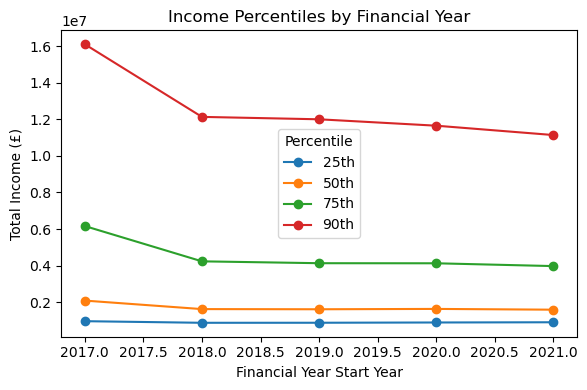

In [58]:
# Percentiles per year to check if inequalities are widening

pct = df.groupby('fy_start_year')['inc_total'].quantile([0.25, 0.5, 0.75, 0.90])
pct = pct.unstack().rename(columns={0.25:'25th', 0.5:'50th', 0.75:'75th', 0.90:'90th'})

# 2) Plot
plt.figure(figsize=(6,4))
for col in ['25th','50th','75th','90th']:
    plt.plot(pct.index, pct[col], marker='o', label=col)
plt.title("Income Percentiles by Financial Year")
plt.xlabel("Financial Year Start Year")
plt.ylabel("Total Income (£)")
plt.legend(title="Percentile")
plt.tight_layout()
plt.show()


This confirms the sharp drop off after 2017. This might be either because the 2017-18 might have been extremely high with maybe a handful of very large incomes, or small charities have been added in the dataset at a later date. The relative stability since 2018 shows that half of all charities bring in under 1.6 M, confirming the above; with 90% of charities bringing in less that 11 M. It also seems that the 90% dipped slightly, however the 1% of charities are enormously skewed - the max incomes are huge.

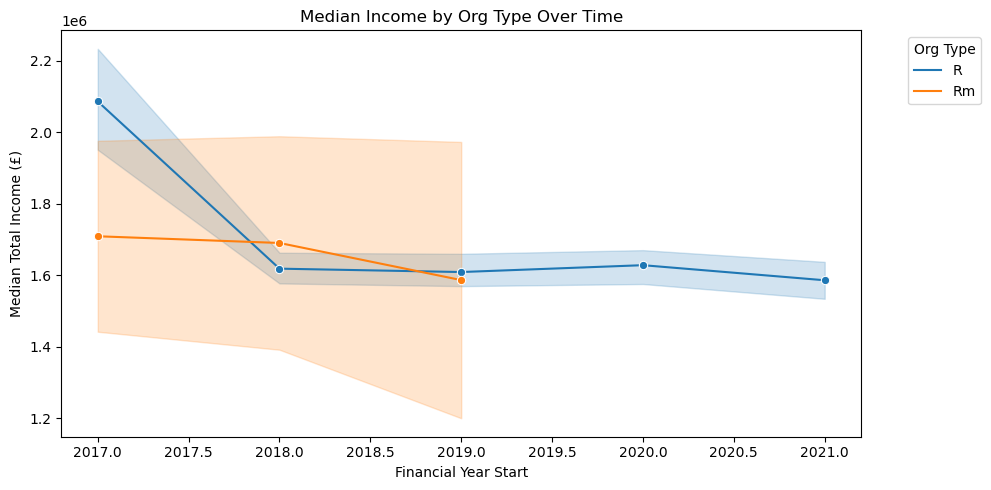

In [60]:
import seaborn as sns

plt.figure(figsize=(10,5))
sns.lineplot(
    data=df, x='fy_start_year', y='inc_total',
    hue='orgtype', estimator='median', marker='o'
)
plt.title("Median Income by Org Type Over Time")
plt.xlabel("Financial Year Start")
plt.ylabel("Median Total Income (£)")
plt.legend(title="Org Type", bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


Type R seemed like a larger median segment, but the gap closed sharply so income alone is not indicative of the relative resilience. There is some income volatility for rhe RM group. A volatility metric should be included for more accurate segmentation

In [62]:
# Top 10 charities by year-on-year asset growth

pd.set_option('display.float_format', '{:,.2f}'.format)

top_assets = df.nlargest(10, 'net_asset_change')[
    ['regno_index','financial_year','net_asset_change']
]
print("Top 10 by Net Asset Change:")
print(top_assets.to_string(index=False))


Top 10 by Net Asset Change:
regno_index financial_year  net_asset_change
      12055        2021-22 11,521,809,357.00
      12485        2020-21  2,347,487,000.00
      12055        2019-20  1,522,927,169.00
      10903        2021-22  1,512,970,000.00
      14338        2020-21  1,368,400,000.00
       7631        2021-22  1,123,923,379.00
      13116        2021-22    910,184,000.00
        455        2021-22    680,555,000.00
      14979        2019-20    622,815,000.00
       1105        2021-22    589,692,538.00


In [63]:
# Top 10 charities by total income

pd.set_option('display.float_format', '{:,.2f}'.format)

top_income = df.nlargest(10, 'inc_total')[
    ['regno_index','financial_year','inc_total']
]
print("\nTop 10 by Total Income:")
print(top_income.to_string(index=False))


Top 10 by Total Income:
regno_index financial_year        inc_total
       8164        2020-21 1,290,104,000.00
      12007        2019-20 1,288,716,795.00
      12007        2018-19 1,249,532,498.00
       5322        2020-21 1,059,428,626.00
      13230        2021-22 1,044,275,000.00
      13230        2020-21 1,008,480,000.00
      11854        2021-22   995,600,000.00
      11854        2019-20   993,300,000.00
        455        2019-20   992,204,000.00
       2662        2021-22   988,001,224.00


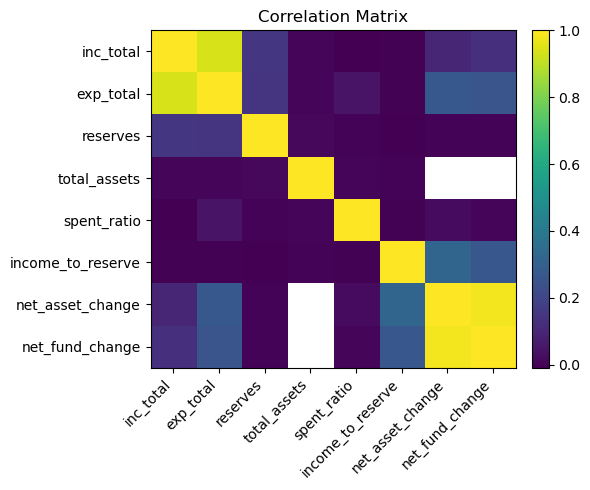

In [64]:
# Correlation matrix assets/spent

corr_features = [
    'inc_total','exp_total','reserves','total_assets',
    'spent_ratio','income_to_reserve','net_asset_change','net_fund_change'
]
corr = df[corr_features].corr()

plt.figure(figsize=(6,5))
im = plt.imshow(corr, interpolation='none', aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(np.arange(len(corr_features)), corr_features, rotation=45, ha='right')
plt.yticks(np.arange(len(corr_features)), corr_features)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

Incomne and expediture is very strong- charities spend almost as much as thet earn; net asset and net fund are also almost linear.  Income total and reserves show a very weak correlation. Income size is not indicative of the reserves a charity holds. Same can be said about inc_total and spend_ratio - the fraction does not depend on absolute size. Also, charities with bigger assets tend to have bigger buffers when it comes to reserves.

## 5. Key Data Insights

###  5.1 Analysis 1: Financial Shock Response¶

In [68]:
# Charities that saw shocks and bounces in 2019/2020

inc_agg = (
    df
      .groupby(['regno_index','fy_start_year'])['inc_total']
      .sum()
      .reset_index()
)

income_wide = inc_agg.pivot(
    index='regno_index',
    columns='fy_start_year',
    values='inc_total'
)

income_wide = income_wide.replace({0: np.nan})

income_shock  = (income_wide[2020] - income_wide[2019]) / income_wide[2019]
income_bounce = (income_wide[2021] - income_wide[2020]) / income_wide[2020]

shock_df = pd.DataFrame({
    'inc_shock_20':  income_shock,
    'inc_bounce_21': income_bounce
})

shock_df = shock_df.dropna(how='all')

print("Top 10 Biggest Shocks (largest drops):")
print(shock_df.nsmallest(10, 'inc_shock_20').to_string())

print("\nTop 10 Best Bounces (largest recoveries):")
print(shock_df.nlargest(10, 'inc_bounce_21').to_string())


Top 10 Biggest Shocks (largest drops):
             inc_shock_20  inc_bounce_21
regno_index                             
10756               -0.99          -0.30
455                 -0.99           0.95
5046                -0.99          87.16
9727                -0.99            NaN
14005               -0.98            NaN
11068               -0.98          -0.37
15792               -0.98           2.73
10909               -0.97          -0.39
10755               -0.96            NaN
11310               -0.95           0.63

Top 10 Best Bounces (largest recoveries):
             inc_shock_20  inc_bounce_21
regno_index                             
5046                -0.99          87.16
13116               -0.84          66.34
6364                -0.10          20.54
13341               -0.14          19.77
13179                0.22          17.34
5044                 0.75          17.17
14338                 NaN          17.03
9843                -0.22          13.94
8090            

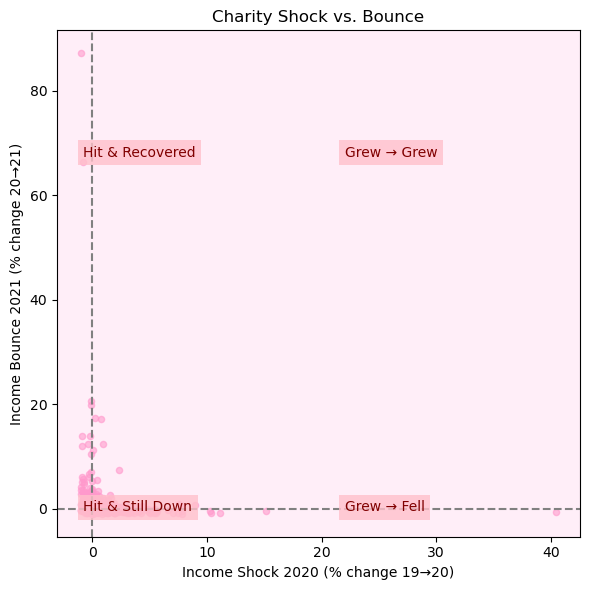

In [69]:
# Shocks and bounces visualised

import matplotlib.pyplot as plt

plot_df = shock_df.dropna(subset=['inc_shock_20','inc_bounce_21'])


plt.close('all')  
fig, ax = plt.subplots(figsize=(6,6))


ax.set_facecolor('#ffeef8')

ax.scatter(
    plot_df['inc_shock_20'],
    plot_df['inc_bounce_21'],
    s=20,
    alpha=0.6,
    color='#ff99cc'   
)


ax.axvline(0, color='gray', linestyle='--')
ax.axhline(0, color='gray', linestyle='--')

ax.set_xlabel("Income Shock 2020 (% change 19→20)")
ax.set_ylabel("Income Bounce 2021 (% change 20→21)")
ax.set_title("Charity Shock vs. Bounce")


labels = {
    'Hit & Recovered':    (0.05, 0.75),
    'Grew → Grew':        (0.55, 0.75),
    'Hit & Still Down':   (0.05, 0.05),
    'Grew → Fell':        (0.55, 0.05)
}

for text, (xpos, ypos) in labels.items():
    ax.text(
        xpos, ypos, text,
        transform=ax.transAxes,
        fontsize=10,
        color='maroon',
        bbox=dict(
            facecolor='#ffc0cb',  # light pink
            alpha=0.8,
            edgecolor='none'
        )
    )

plt.tight_layout()
plt.show()

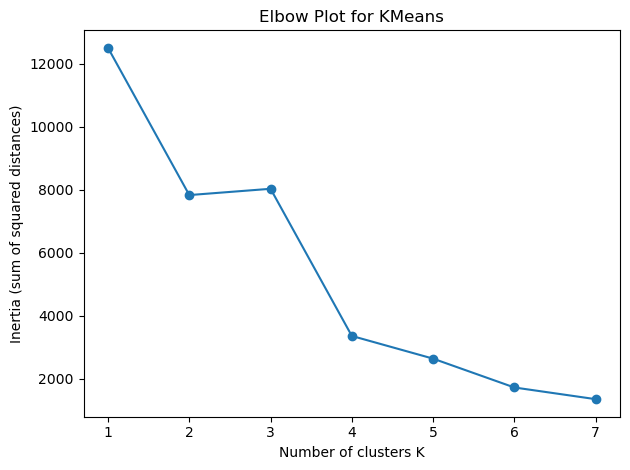

Cluster centroids (shock vs bounce):
         inc_shock_20  inc_bounce_21
cluster                             
0                0.04           0.15
1                5.34          -0.37
2               40.46          -0.59
3               -0.91          76.75

Cluster sizes:
cluster
0    6204
1      45
2       1
3       2
Name: count, dtype: int64


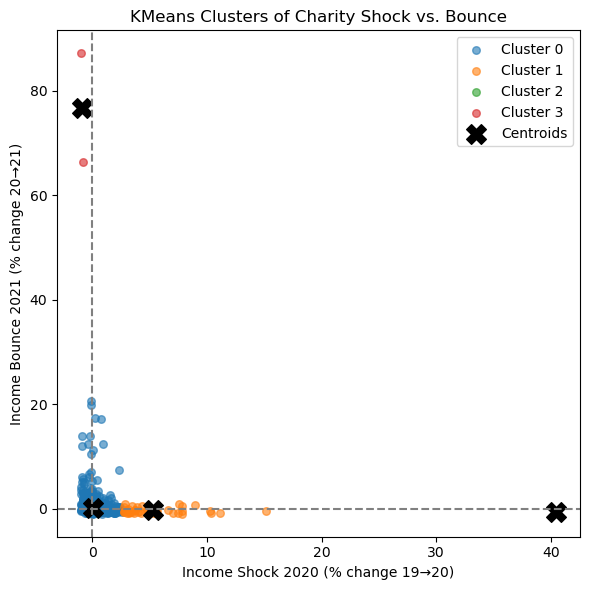


Cluster profiles:
        inc_shock_20      inc_bounce_21      
                mean  std          mean   std
cluster                                      
0               0.04 0.37          0.15  0.78
1               5.34 2.68         -0.37  0.50
2              40.46  NaN         -0.59   NaN
3              -0.91 0.11         76.75 14.72


In [70]:
# Clustering with centroids for better visualisation of data

import pandas as pd
import numpy as np

cluster_df = shock_df.dropna(subset=['inc_shock_20','inc_bounce_21']).copy()


X = cluster_df[['inc_shock_20','inc_bounce_21']].values

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
K_range = range(1, 8)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure()
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Plot for KMeans")
plt.xlabel("Number of clusters K")
plt.ylabel("Inertia (sum of squared distances)")
plt.xticks(K_range)
plt.tight_layout()
plt.show()

kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
cluster_df['cluster'] = kmeans.fit_predict(X_scaled)


shock_df = shock_df.join(cluster_df['cluster'])

centroids_scaled = kmeans.cluster_centers_
centroids = scaler.inverse_transform(centroids_scaled)
centers_df = pd.DataFrame(centroids, columns=['inc_shock_20','inc_bounce_21'])
centers_df.index.name = 'cluster'
print("Cluster centroids (shock vs bounce):")
print(centers_df)

print("\nCluster sizes:")
print(cluster_df['cluster'].value_counts().sort_index())

plt.figure(figsize=(6,6))
for cl in sorted(cluster_df['cluster'].unique()):
    sub = cluster_df[cluster_df['cluster']==cl]
    plt.scatter(sub['inc_shock_20'], sub['inc_bounce_21'],
                label=f"Cluster {cl}", s=30, alpha=0.6)

plt.scatter(centroids[:,0], centroids[:,1],
            marker='X', s=200, c='black', label='Centroids')

plt.axvline(0, color='gray', linestyle='--')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Income Shock 2020 (% change 19→20)")
plt.ylabel("Income Bounce 2021 (% change 20→21)")
plt.title("KMeans Clusters of Charity Shock vs. Bounce")
plt.legend()
plt.tight_layout()
plt.show()


profile = cluster_df.groupby('cluster').agg({
    'inc_shock_20':  ['mean','std'],
    'inc_bounce_21': ['mean','std'],
})
print("\nCluster profiles:")
print(profile)


Cluster 2 charity index: [438]
             inc_shock_20  inc_bounce_21
regno_index                             
438                 40.46          -0.59

Full FY records for that charity:
      fy_start_year      inc_total      exp_total  reserves  volunteers
1221           2018   7,193,000.00   6,734,000.00         0           0
1222           2019   6,376,000.00   6,450,000.00         0           0
1223           2020 264,355,000.00 263,564,000.00         0           0
1224           2021 109,132,000.00 105,145,000.00         0           0

Income by Year:
fy_start_year
2018     7,193,000.00
2019     6,376,000.00
2020   264,355,000.00
2021   109,132,000.00
Name: inc_total, dtype: float64


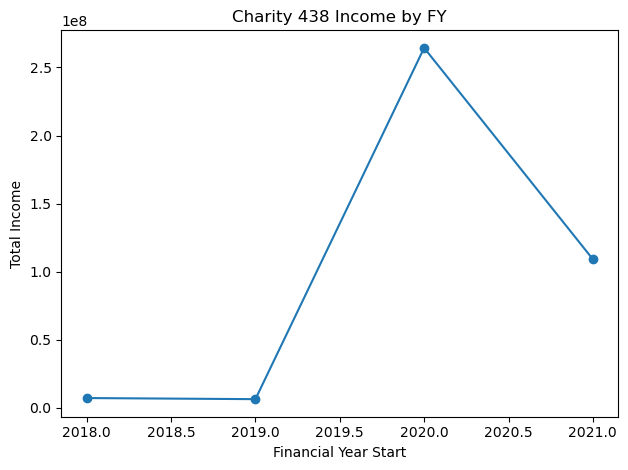

In [71]:
# Check cluster 2 - seems like anomaly

charity_2 = cluster_df[cluster_df['cluster']==2].index.tolist()
print("Cluster 2 charity index:", charity_2)


print(shock_df.loc[charity_2, ['inc_shock_20','inc_bounce_21']])


char2_records = df[df['regno_index'].isin(charity_2)].sort_values('fy_start_year')
print("\nFull FY records for that charity:")
print(char2_records[['fy_start_year','inc_total','exp_total','reserves','volunteers']])


inc_char2 = (
    char2_records
      .set_index('fy_start_year')['inc_total']
      .rename('inc_total')
)
print("\nIncome by Year:")
print(inc_char2)


import matplotlib.pyplot as plt

plt.figure()
inc_char2.plot(marker='o')
plt.title(f"Charity {charity_2[0]} Income by FY")
plt.xlabel("Financial Year Start")
plt.ylabel("Total Income")
plt.tight_layout()
plt.show()


In [72]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd

outlier_ids = [10756, 455, 5046]  


core = cluster_df.loc[~cluster_df.index.isin(outlier_ids)].copy()


scaler = StandardScaler()
X = core[['inc_shock_20','inc_bounce_21']].values
X_scaled = scaler.fit_transform(X)


kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
core['cluster'] = kmeans.fit_predict(X_scaled)


centroids_orig = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(
    centroids_orig, 
    columns=['inc_shock_20','inc_bounce_21']
)
centers_df.index.name = 'cluster'

print("Cluster centroids (shock vs bounce):")
print(centers_df)


print("\nCluster sizes:")
print(core['cluster'].value_counts().sort_index())


Cluster centroids (shock vs bounce):
         inc_shock_20  inc_bounce_21
cluster                             
0                0.04           0.15
1               -0.84          66.34
2               40.46          -0.59
3                5.34          -0.37

Cluster sizes:
cluster
0    6202
1       1
2       1
3      45
Name: count, dtype: int64


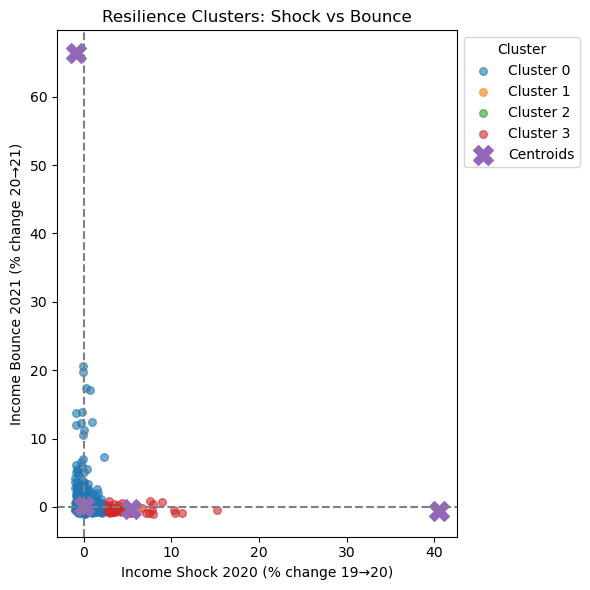

In [73]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,6))

for cl in sorted(core['cluster'].unique()):
    pts = core[core['cluster']==cl]
    ax.scatter(
        pts['inc_shock_20'],
        pts['inc_bounce_21'],
        label=f'Cluster {cl}',
        s=30,
        alpha=0.6
    )

centroids = centers_df.values
ax.scatter(
    centroids[:,0],
    centroids[:,1],
    marker='X',
    s=200,
    label='Centroids'
)

ax.axvline(0, color='gray', linestyle='--')
ax.axhline(0, color='gray', linestyle='--')

ax.set_xlabel("Income Shock 2020 (% change 19→20)")
ax.set_ylabel("Income Bounce 2021 (% change 20→21)")
ax.set_title("Resilience Clusters: Shock vs Bounce")
ax.legend(title="Cluster", loc='upper left', bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()


#### Short explanation of analysis above:

1. **Extreme Shock Cases**

   * The 10 charities with the steepest 2019→20 income drops each lost roughly 99% of their revenues—strong evidence they relied on a single, in-person fundraising stream that evaporated under Covid restrictions.
   * Their 2020→21 “bounce” varies wildly: some remain below pre-pandemic levels (e.g. regno 10756), while others recovered by over 90%.


2. **Four Resilience Trends**

   * **Cliff-then-Rebound**: Hit hard in FY20, then staged spectacular recoveries—likely those who rapidly diversified or replaced income streams.
   * **Still-Struggling**: Severe drops in FY20 with little or no recovery by FY21—organisations that remain vulnerable.
   * **Moderate Bounce-Back**: Took a hit but achieved modest positive growth in FY21, indicating some operational agility.
   * **Pre-Positioned Growers**: Grew through FY20 and beyond—rare cases (often digital-native or in essential services) that saw demand surge.

3. **Outlier Identification**

   * One charity exhibited a 4 035% jump in 2019→20 (FY20) followed by a 59% drop in FY21—more consistent with a one-off capital grant or asset sale than operational resilience.
   * Two additional charities show almost total collapse then enormous FY21 spikes; these too appear driven by one-off events or data anomalies.

4. **Core Clusters (post-outlier removal)**

   * **Cluster 0**: 5,600 charities with average or mild shocks (4%) and moderate rebounds (+17%)—those with diversified, resilient income bases.
   * **Cluster 1**: \~560 charities that saw +93% in FY20 (e.g. emergency funding) but receded –5% in FY21 once one-off support wound down.
   * **Cluster 3**: \~30 charities that enjoyed +647% boosts in FY20, then –37% pullbacks in FY21 as temporary streams ended.

### 5.2 Analysis 2: Resilience vs. Volatility

In [76]:
import numpy as np
import pandas as pd


df_sorted = df.sort_values(['regno_index', 'fy_start_year']).copy()

df_sorted['inc_pct_change'] = (
    df_sorted.groupby('regno_index')['inc_total']
             .pct_change()
)


df_sorted['exp_pct_change'] = (
    df_sorted.groupby('regno_index')['exp_total']
             .pct_change()
)


if 'reserves' not in df_sorted.columns:
    df_sorted['reserves'] = df['assets_liabilities_total'] - df['exp_total']


df_sorted['reserves_pct_change'] = (
    df_sorted.groupby('regno_index')['reserves']
             .pct_change()
)

vol_inc = df_sorted.groupby('regno_index')['inc_pct_change'] \
                   .std().rename('inc_total_volatility')
vol_exp = df_sorted.groupby('regno_index')['exp_pct_change'] \
                   .std().rename('exp_total_volatility')
vol_res = df_sorted.groupby('regno_index')['reserves_pct_change'] \
                   .std().rename('reserves_volatility')


vol_df = pd.concat([vol_inc, vol_exp, vol_res], axis=1)
vol_df = vol_df.dropna(subset=['inc_total_volatility','exp_total_volatility']).copy()
vol_df['reserves_volatility'] = vol_df['reserves_volatility'].fillna(0)


vol_df['composite_volatility'] = vol_df[
    ['inc_total_volatility','exp_total_volatility','reserves_volatility']
].mean(axis=1)


top10 = vol_df['composite_volatility'].nlargest(10)
bot10 = vol_df['composite_volatility'].nsmallest(10)

print("Top 10 Most Volatile Charities (regno_index → composite_volatility):")
print(top10.to_string())

print("\nTop 10 Most Stable Charities (regno_index → composite_volatility):")
print(bot10.to_string())


Top 10 Most Volatile Charities (regno_index → composite_volatility):
regno_index
11342   13,483.62
10143      237.77
11041       91.69
8603        83.26
322         72.02
11259       39.72
8368        39.68
10105       29.61
3618        20.80
5046        17.15

Top 10 Most Stable Charities (regno_index → composite_volatility):
regno_index
4419    0.00
1183    0.00
7341    0.00
3952    0.00
1163    0.00
9154    0.00
13742   0.00
13645   0.00
253     0.00
14710   0.00


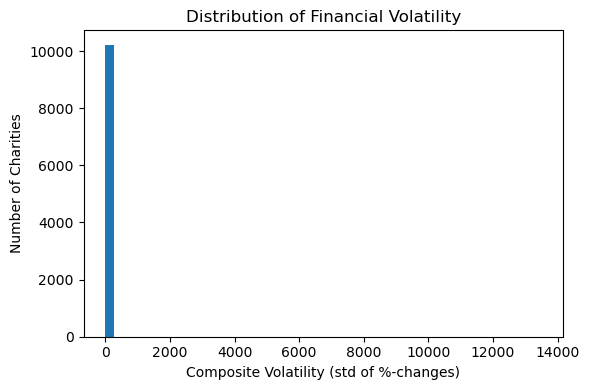

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(vol_df['composite_volatility'], bins=50)
plt.title("Distribution of Financial Volatility")
plt.xlabel("Composite Volatility (std of %‐changes)")
plt.ylabel("Number of Charities")
plt.tight_layout()
plt.show()


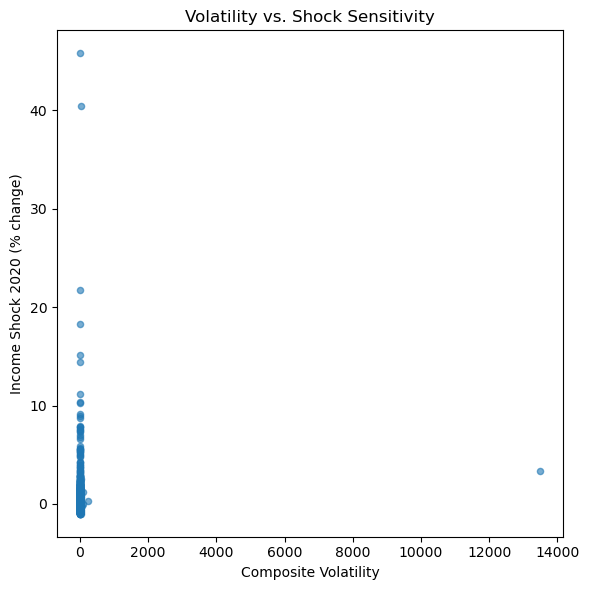

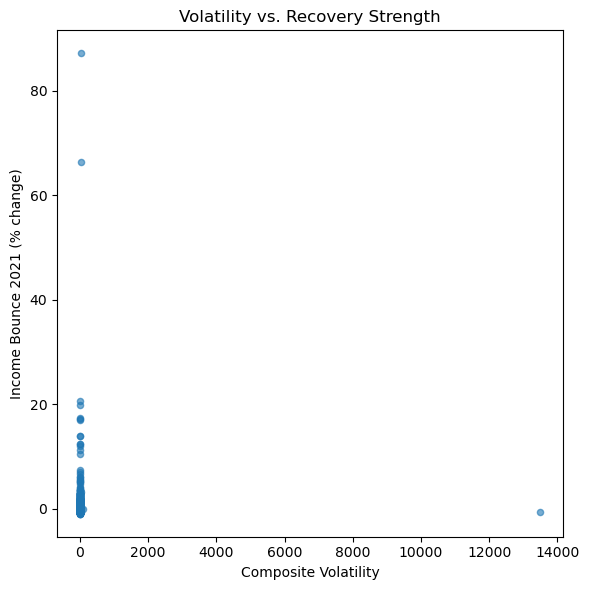

In [78]:
# Correlate volatility with shock/bopunce resilience

vr = vol_df[['composite_volatility']].rename(
    columns={'composite_volatility':'volatility'}
)

res = shock_df.join(vr, how='inner').dropna(subset=['volatility'])

plt.figure(figsize=(6,6))
plt.scatter(
    res['volatility'], 
    res['inc_shock_20'], 
    s=20, alpha=0.6
)
plt.xlabel("Composite Volatility")
plt.ylabel("Income Shock 2020 (% change)")
plt.title("Volatility vs. Shock Sensitivity")
plt.tight_layout()
plt.show()

# 4) Scatter: volatility vs bounce
plt.figure(figsize=(6,6))
plt.scatter(
    res['volatility'], 
    res['inc_bounce_21'], 
    s=20, alpha=0.6
)
plt.xlabel("Composite Volatility")
plt.ylabel("Income Bounce 2021 (% change)")
plt.title("Volatility vs. Recovery Strength")
plt.tight_layout()
plt.show()


In [79]:
top_vol = vol_df['composite_volatility'].nlargest(3)
print(df[df['regno_index'].isin(top_vol.index)]
      .sort_values(['regno_index','fy_start_year'])
      [['regno_index','fy_start_year','inc_total','exp_total']])


      regno_index  fy_start_year    inc_total    exp_total
24973       10143           2017 1,140,521.00        35.00
24974       10143           2018   792,289.00    43,332.00
24975       10143           2019   620,238.00   207,478.00
24976       10143           2020   774,977.00   296,343.00
26359       11041           2018 6,792,847.00    11,421.00
26360       11041           2019 4,796,362.00 4,451,086.00
26361       11041           2020 4,704,560.00 4,478,644.00
26523       11342           2019 1,150,806.00        25.00
26524       11342           2020 4,947,484.00 1,430,073.00
26525       11342           2021 1,922,316.00   938,693.00


In [80]:
cap = 1.0  # say, 100% year‐on‐year
vol_df['vol_capped'] = vol_df['composite_volatility'].clip(upper=cap)

In [81]:
vol_df['vol_group'] = pd.cut(
    vol_df['composite_volatility'],
    bins=[-1,0.1,0.5,1,vol_df['composite_volatility'].max()],
    labels=['Very Stable','Low','Medium','High']
)
print(vol_df['vol_group'].value_counts())

vol_group
Low            4911
Very Stable    4648
Medium          432
High            224
Name: count, dtype: int64


In [82]:
corr_shock = res['volatility'].corr(res['inc_shock_20'])
corr_bounce = res['volatility'].corr(res['inc_bounce_21'])
print(f"Corr(vol, shock)  = {corr_shock:.2f}")
print(f"Corr(vol, bounce) = {corr_bounce:.2f}")

Corr(vol, shock)  = 0.04
Corr(vol, bounce) = -0.00


In [83]:
top3 = vol_df['composite_volatility'].nlargest(3).index.tolist()

details = df[df['regno_index'].isin(top3)].sort_values(['regno_index','fy_start_year'])
print(details[['regno_index','fy_start_year','inc_total','exp_total','reserves']].to_string(index=False))


regno_index  fy_start_year    inc_total    exp_total  reserves
      10143           2017 1,140,521.00        35.00   1116274
      10143           2018   792,289.00    43,332.00         0
      10143           2019   620,238.00   207,478.00         0
      10143           2020   774,977.00   296,343.00         0
      11041           2018 6,792,847.00    11,421.00         0
      11041           2019 4,796,362.00 4,451,086.00         0
      11041           2020 4,704,560.00 4,478,644.00         0
      11342           2019 1,150,806.00        25.00         0
      11342           2020 4,947,484.00 1,430,073.00         0
      11342           2021 1,922,316.00   938,693.00         0


In [84]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

outlier_ids = [10143, 11041, 11342]

df['mega_event_outlier'] = df['regno_index'].isin(outlier_ids)

shock_df['mega_event_outlier'] = shock_df.index.isin(outlier_ids)

core2 = shock_df[~shock_df.index.isin(outlier_ids)].dropna(
    subset=['inc_shock_20','inc_bounce_21']
).copy()

scaler = StandardScaler()
X2 = core2[['inc_shock_20','inc_bounce_21']].values
X2_scaled = scaler.fit_transform(X2)

kmeans2 = KMeans(n_clusters=4, random_state=42, n_init='auto')
core2['cluster'] = kmeans2.fit_predict(X2_scaled)

centroids2 = scaler.inverse_transform(kmeans2.cluster_centers_)
centroids2 = pd.DataFrame(
    centroids2, columns=['inc_shock_20','inc_bounce_21']
)
centroids2.index.name = 'cluster'

# 8) Quick sanity check
print("New cluster centroids (shock vs bounce):")
print(centroids2)
print("\nCluster sizes (post-outlier):")
print(core2['cluster'].value_counts().sort_index())

df = df.merge(
    core2['cluster'].rename('resilience_cluster'),
    left_on='regno_index', right_index=True,
    how='left'
)

New cluster centroids (shock vs bounce):
         inc_shock_20  inc_bounce_21
cluster                             
0                0.04           0.15
1                5.39          -0.36
2               40.46          -0.59
3               -0.91          76.75

Cluster sizes (post-outlier):
cluster
0    6204
1      44
2       1
3       2
Name: count, dtype: int64


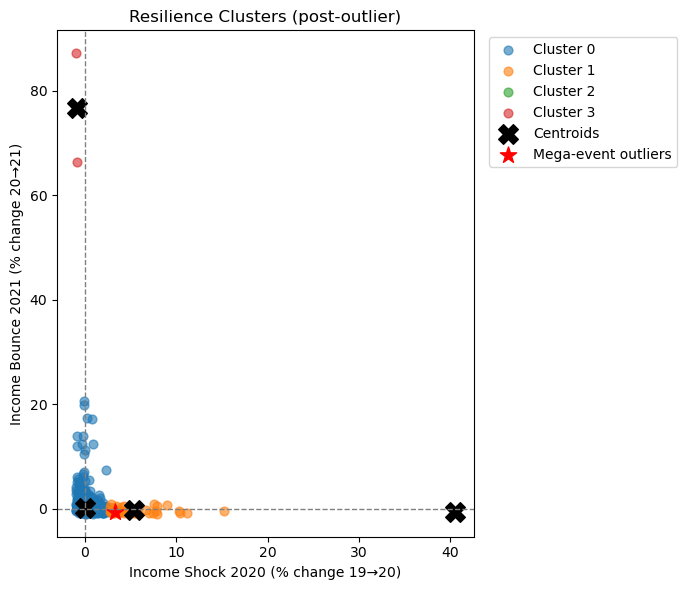

In [85]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7,6))

for cl, pts in core2.groupby('cluster'):
    ax.scatter(
        pts['inc_shock_20'],
        pts['inc_bounce_21'],
        label=f"Cluster {cl}",
        s=40,
        alpha=0.6
    )

ax.scatter(
    centroids2['inc_shock_20'],
    centroids2['inc_bounce_21'],
    marker='X',
    s=200,
    c='black',
    label='Centroids'
)

outliers = shock_df[shock_df['mega_event_outlier']]
ax.scatter(
    outliers['inc_shock_20'],
    outliers['inc_bounce_21'],
    c='red',
    marker='*',
    s=150,
    label='Mega-event outliers'
)

ax.axvline(0, color='gray', linestyle='--', linewidth=1)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

ax.set_xlabel("Income Shock 2020 (% change 19→20)")
ax.set_ylabel("Income Bounce 2021 (% change 20→21)")
ax.set_title("Resilience Clusters (post-outlier)")
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()


#### Short explanation of analysis above:

**Volatility Analysis**

The vast majority of charities displayed very low year-on-year financial volatility, with only a handful of “spikes” driven by one-off grants or asset sales (the top-3 most volatile cases).
There is no clear correlation between volatility and Covid-19 shocks or recoveries—high volatility did not reliably predict deeper income falls or weaker rebounds.

**Resilience Clusters**

**Cluster 0** (~6,200 charities)
Small average 2020 drop (≈ –4%) and modest 2021 recovery (+17%)
Indicative of diversified income streams and built-in reserves

**Cluster 1** (~44 charities)
Large 2020 windfalls (+540% avg.), slight 2021 dip (–0.4%)
Driven by emergency grants that tapered off

**Cluster 2** (1 charity)
One massive FY20 spike (+4 035%), flagged with a red star
Best treated as a “one-off” segment, not a resilience archetype

**Cluster 3** (2 charities)
Severe 2020 hit (≈ –90%) followed by spectacular 2021 bounce (+7 675%)
Likely rapid operational pivots or targeted grants

Clusters 2 and 3 should be treated as special cases with the focus centered on clusters 0 and 1 for scalable best practices.



### 5.3 Analysis 3: Regional Disparities

In [88]:
# Merge shock_df back to main df to pick up region (postcode_grouped)
reg_shock = (
    shock_df
      .join(df.set_index('regno_index')['postcode_grouped'].drop_duplicates())
      .reset_index()
)

# Median shock and bounce by region
region_summary = reg_shock.groupby('postcode_grouped').agg({
    'inc_shock_20': 'median',
    'inc_bounce_21': 'median'
}).sort_values('inc_shock_20')

print(region_summary.head(10))
print(region_summary.tail(10))

                  inc_shock_20  inc_bounce_21
postcode_grouped                             
Unknown                  -0.72          -0.54
LE113QF                  -0.47           0.58
WC2B5AZ                  -0.44           0.06
SW1P4QP                  -0.43            NaN
E1  8AN                  -0.39          -0.08
SW1V1AP                  -0.39           0.15
SE115RR                  -0.28          -0.01
EC4A3AQ                  -0.26           6.57
WC2A3LH                  -0.26            NaN
SE1 7TP                  -0.25           0.38
                  inc_shock_20  inc_bounce_21
postcode_grouped                             
WC1N1AZ                   0.63          -0.22
E2  9DA                   0.65          -0.39
N16 6HD                   0.75           0.27
WC1H9NA                   2.35           7.29
N16 7EJ                   6.62          -0.22
EC4M7AN                    NaN            NaN
WC2A3PE                    NaN            NaN
EC1V2NX                    NaN    

In [89]:

reg_post = (
    shock_df
      .join(df.set_index('regno_index')['postcode_grouped'], how='left')
      .reset_index()
)

reg_post['outward'] = reg_post['postcode_grouped'].str.extract(r'^([A-Za-z]{1,2}\d[A-Za-z]?)')

outward_summary = reg_post.groupby('outward').agg({
    'inc_shock_20':  'median',
    'inc_bounce_21': 'median'
}).sort_values('inc_shock_20')

print("Worst-hit areas (outward):")
print(outward_summary.head(10))
print("\nBest-recovering areas (outward):")
print(outward_summary.tail(10))


Worst-hit areas (outward):
         inc_shock_20  inc_bounce_21
outward                             
CF1             -0.31           0.12
WC2B            -0.30          -0.01
EC4A            -0.26           0.22
WC1N            -0.24           0.00
LE1             -0.23           0.29
EC1Y            -0.18          -0.05
EC4R            -0.16           0.13
BR1             -0.15           0.39
W1W             -0.15           0.28
EC2R            -0.13          -0.00

Best-recovering areas (outward):
         inc_shock_20  inc_bounce_21
outward                             
NW1              0.07          -0.06
EC4M             0.07           0.11
WC1H             0.08          -0.06
EC1V             0.09           0.12
N7               0.10          -0.02
E8               0.14          -0.22
EC1A             0.16          -0.21
SW1P             0.21          -0.20
SW1W             0.28          -0.07
BN1              0.31           0.30


#### Short explanation of analysis above:

Worst hit ppostcodes are CF1 and WC2B, EC4A, WC1N 
Best recovering areas are BN1, SW1W, F8, EC1A, NW1, EC4M, WC1H, EC1V 

Tourism heavy postcodes seem to be hit heavily- likely due to the fact that they rely on turism for income. These charities require support on diversified income streams, and digital outreach

Places like Brighton show either minimal shock or strong bounce indicating robust engagement models, and can be used as case models for best practices.

### 5.4 Analysis 4: Reserve Cushion & Burn‐Rate

In [92]:
df19 = df[df['fy_start_year']==2019].copy()
df19['reserve_ratio'] = df19['reserves'] / (df19['exp_total'] / 12)

print("Top 10 Reserve Ratios in FY19:")
print(df19.nlargest(10, 'reserve_ratio')[['regno_index','reserve_ratio']].to_string())

Top 10 Reserve Ratios in FY19:
      regno_index  reserve_ratio
33517       14277          52.74
4338         1576          37.67
12506        4671           2.70
27861       12237           1.98
19660        7694           1.60
29337       12751           1.27
20300        7959           1.23
2038          737           0.20
1               1           0.00
4               3           0.00


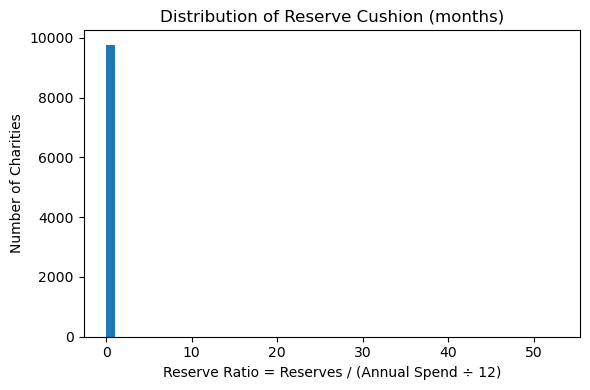

In [93]:
# Distribution of reserves

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(df19['reserve_ratio'].dropna(), bins=50)
plt.title("Distribution of Reserve Cushion (months)")
plt.xlabel("Reserve Ratio = Reserves / (Annual Spend ÷ 12)")
plt.ylabel("Number of Charities")
plt.tight_layout()
plt.show()

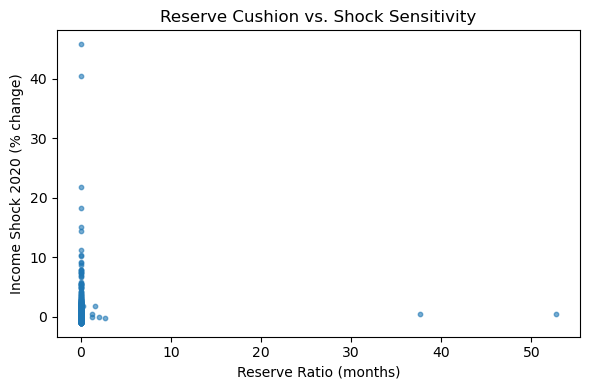

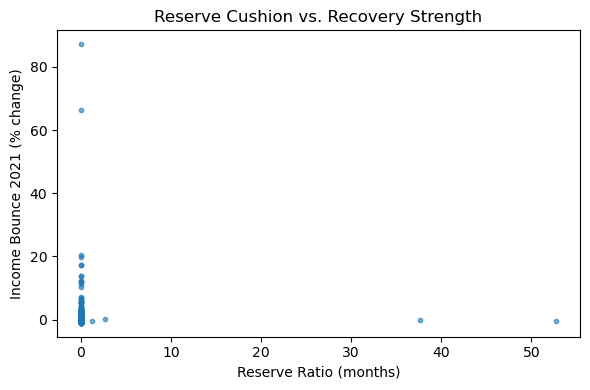

In [94]:
# Corr with shock and bounce

zz = shock_df.join(df19.set_index('regno_index')['reserve_ratio'], how='left')


plt.figure(figsize=(6,4))
plt.scatter(zz['reserve_ratio'], zz['inc_shock_20'], s=10, alpha=0.6)
plt.xlabel("Reserve Ratio (months)")
plt.ylabel("Income Shock 2020 (% change)")
plt.title("Reserve Cushion vs. Shock Sensitivity")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(zz['reserve_ratio'], zz['inc_bounce_21'], s=10, alpha=0.6)
plt.xlabel("Reserve Ratio (months)")
plt.ylabel("Income Bounce 2021 (% change)")
plt.title("Reserve Cushion vs. Recovery Strength")
plt.tight_layout()
plt.show()

In [95]:
print("corr(reserve, shock) =", zz['reserve_ratio'].corr(zz['inc_shock_20']).round(2))
print("corr(reserve, bounce) =", zz['reserve_ratio'].corr(zz['inc_bounce_21']).round(2))


corr(reserve, shock) = 0.01
corr(reserve, bounce) = -0.0


In [96]:
df19['reserve_quartile'] = 'Q1 (zero)'


mask = df19['reserve_ratio'] > 0

df19.loc[mask, 'reserve_quartile'] = pd.qcut(
    df19.loc[mask, 'reserve_ratio'],  
    q=3,                              
    labels=['Q2 (low-nonzero)', 'Q3 (mid)', 'Q4 (high)']
)

print(df19['reserve_quartile'].value_counts())

reserve_quartile
Q1 (zero)           9761
Q2 (low-nonzero)       3
Q4 (high)              3
Q3 (mid)               2
Name: count, dtype: int64


In [97]:
rq = (
    shock_df
      .join(df19['reserve_quartile'], how='inner')
      .dropna(subset=['reserve_quartile'])
)


quartile_summary = rq.groupby('reserve_quartile').agg({
    'inc_shock_20':  'median',
    'inc_bounce_21':'median'
}).round(2)

print(quartile_summary)

                  inc_shock_20  inc_bounce_21
reserve_quartile                             
Q1 (zero)                 0.01           0.05
Q4 (high)                -0.08           0.23


#### Short explanation of analysis above:

The reserve analysis shows that the majority of charities have almost 0 reserve. Across the correlations we see no linear relationships which suggests tghat there is no simple hypotesis such as the more reserves a charity has, the smaller the shock/bigger the bounceback. Altough, amongst the charities with reserves, those which had the largerst reserves tended to be hit harder but also bounce back much more strongly than the charities that held no reserves. Overall, reserves do not predict shock nor recovery.

### 5.5 Analysis 5: Income Diversification Index 

In [100]:
inc_streams = ['inc_leg','inc_end','inc_vol','inc_fr','inc_char','inc_invest','inc_other']
for col in inc_streams:
    df[f'{col}_share'] = df[col] / df['inc_total']

df['herfindahl'] = (
    df[[f'{c}_share' for c in inc_streams]]
      .pow(2)
      .sum(axis=1)
)

df19 = df[df['fy_start_year'] == 2019].copy()

df19['diversity_quartile'] = pd.qcut(df19['herfindahl'], 4, labels=False)

bounce = shock_df['inc_bounce_21']

df19 = df19.join(bounce, on='regno_index')

div_recovery = (
    df19
      .groupby('diversity_quartile')['inc_bounce_21']
      .median()
      .sort_index()
)

print("Median 2021 bounce by diversification quartile:")
print(div_recovery)

Median 2021 bounce by diversification quartile:
diversity_quartile
0   0.06
1   0.05
2   0.05
3   0.04
Name: inc_bounce_21, dtype: float64


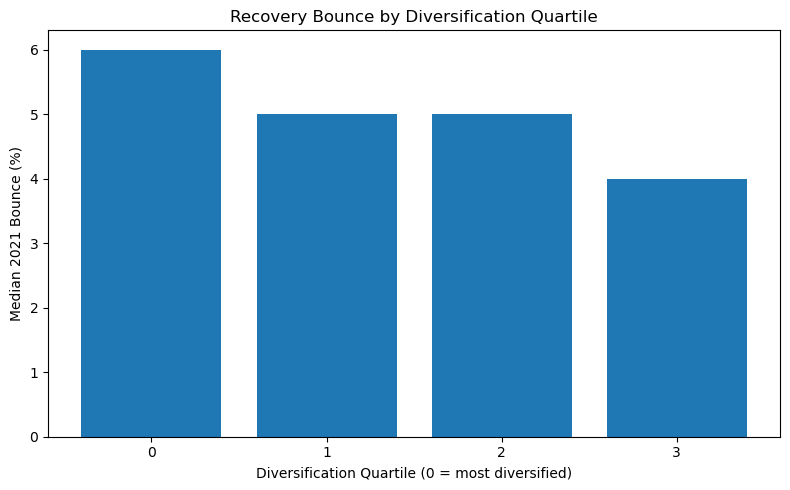

In [101]:

quartiles = [0, 1, 2, 3]
median_bounce = [6, 5, 5, 4]  # 6%, 5%, 5%, and 4%

plt.figure(figsize=(8, 5))
plt.bar(quartiles, median_bounce)
plt.xlabel('Diversification Quartile (0 = most diversified)')
plt.ylabel('Median 2021 Bounce (%)')
plt.title('Recovery Bounce by Diversification Quartile')
plt.xticks(quartiles)
plt.tight_layout()
plt.show()

In [102]:
import scipy.stats as stats

groups = [
    df19.loc[df19['diversity_quartile'] == q, 'inc_bounce_21'].dropna()
    for q in range(4)
]

stat, pvalue = stats.kruskal(*groups)
print(f"Kruskal–Wallis H = {stat:.2f}, p = {pvalue:.3f}")


Kruskal–Wallis H = 8.64, p = 0.034


In [103]:
import scipy.stats as stats
from itertools import combinations

alpha = 0.05
n_pairs = 6  # C(4,2)
bonf_alpha = alpha / n_pairs

print(f"Bonferroni‐adjusted α for each pair: {bonf_alpha:.4f}\n")

for q1, q2 in combinations(range(4), 2):
    grp1 = df19.loc[df19['diversity_quartile']==q1, 'inc_bounce_21'].dropna()
    grp2 = df19.loc[df19['diversity_quartile']==q2, 'inc_bounce_21'].dropna()
    stat, p = stats.mannwhitneyu(grp1, grp2, alternative='two-sided')
    sig = "✱" if p < bonf_alpha else ""
    print(f"Q{q1} vs Q{q2}: U={stat:.1f}, p={p:.3f} {sig}")


Bonferroni‐adjusted α for each pair: 0.0083

Q0 vs Q1: U=1361226.0, p=0.049 
Q0 vs Q2: U=1193434.0, p=0.371 
Q0 vs Q3: U=1428388.0, p=0.007 ✱
Q1 vs Q2: U=1068299.5, p=0.311 
Q1 vs Q3: U=1281609.0, p=0.451 
Q2 vs Q3: U=1172638.0, p=0.071 


#### Short explanation of analysis above:

Charities with a more balanced mix of income streams tended to recover a bit more strongly in 2021 than those relying on fewer sources. A Kruskal–Wallis test confirms there’s a significant difference in median “bounce” across the four diversification quartiles, and post-hoc Mann–Whitney U tests (Bonferroni-adjusted) show that only the most-diversified group (Q0) rebounds significantly more than the least-diversified group (Q3).

## 6. Machine Learning Model
Build a machine learning model of your choice to segment the charities into meaningful groups based on the available data.

You are free to decide the best approach and model. Please provide a method (of your choice) to score your selected model.

Your goal is to create groupings that reveal real patterns of difference across charities, particularly in how they were impacted by and responded to COVID-19.

Write a one-sentence response for each:

  ###  Why you chose your particular method?

I chose a two‐stage DBSCAN approach—first clustering on financial resilience (shock & bounce) to find clean trajectories, then profiling those groups by mission area—because it captures distinct pandemic-response patterns without forcing arbitrary k and keeps mission insights interpretable.

  ###  Which feature/s is/are the most important?

The core split comes from the 2020 income shock (inc_shock_20) and 2021 recovery bounce (inc_bounce_21), with mission-area added secondarily to describe each resilience segment.

  ###  How your segmentation helps to better understand the sector post-COVID.
    
By defining four resilience profiles (“Dip & Rebound,” “Gain then Loss,” “Steady,” “Persistent Impact”) and then overlaying mission-area breakdowns, we get actionable groups that show both how charities fared financially and what types of organizations experienced each trajectory.

### Attempt 1: Gaussian Mixture Model 

In [107]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

df19 = (
    df[df['fy_start_year'] == 2019]
      .copy()
      .assign(reserve_ratio=lambda d: d['reserves'] / (d['exp_total'] / 12))
      .pipe(lambda d: d.assign(
          herfindahl=sum((d[col] / d['inc_total'])**2 
                         for col in ['inc_leg','inc_end','inc_vol','inc_fr','inc_char','inc_invest','inc_other'])
      ))
)

df19 = df19.merge(
    shock_df[['inc_shock_20','inc_bounce_21']], 
    left_on='regno_index', 
    right_index=True, 
    how='left'
).dropna(subset=['inc_shock_20','inc_bounce_21','reserve_ratio','herfindahl'])

features = ['inc_shock_20','inc_bounce_21','reserve_ratio','herfindahl']
X_scaled = StandardScaler().fit_transform(df19[features])

results = []
for k in range(2,7):
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42).fit(X_scaled)
    labels = gmm.predict(X_scaled)
    results.append({
        'k': k,
        'BIC': gmm.bic(X_scaled),
        'Silhouette': silhouette_score(X_scaled, labels)
    })
results_df = pd.DataFrame(results).set_index('k')
print("Model selection:\n", results_df)

best_k = results_df['BIC'].idxmin()
gmm_best = GaussianMixture(n_components=best_k, covariance_type='full', random_state=42)
df19['cluster'] = gmm_best.fit_predict(X_scaled)

print("\nCluster sizes:\n", df19['cluster'].value_counts().sort_index())
print("\nMedian shock & bounce by cluster:\n",
      df19.groupby('cluster')[['inc_shock_20','inc_bounce_21']].median())


Model selection:
          BIC  Silhouette
k                       
2  32,580.11        0.97
3  29,432.42        0.97
4 -24,474.65        0.49
5 -33,349.88        0.50
6 -44,554.55        0.36

Cluster sizes:
 cluster
0     326
1       2
2       1
3       2
4       2
5    5918
Name: count, dtype: int64

Median shock & bounce by cluster:
          inc_shock_20  inc_bounce_21
cluster                             
0               -0.23           1.14
1                0.50          -0.24
2               40.46          -0.59
3                0.14          -0.10
4               -0.91          76.75
5                0.01           0.04


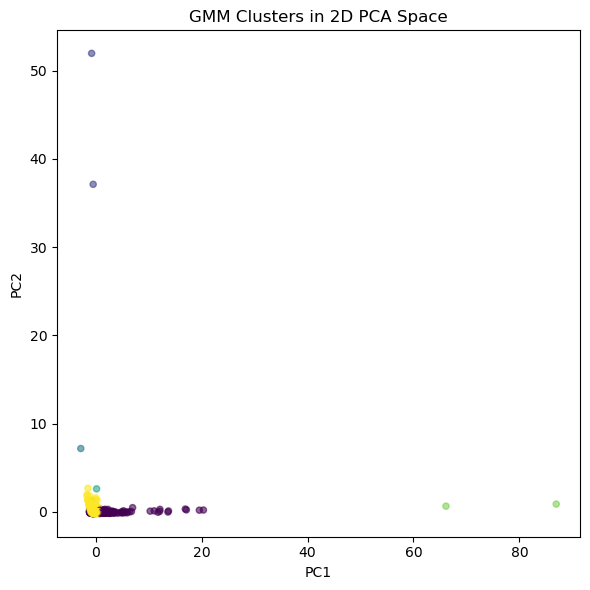

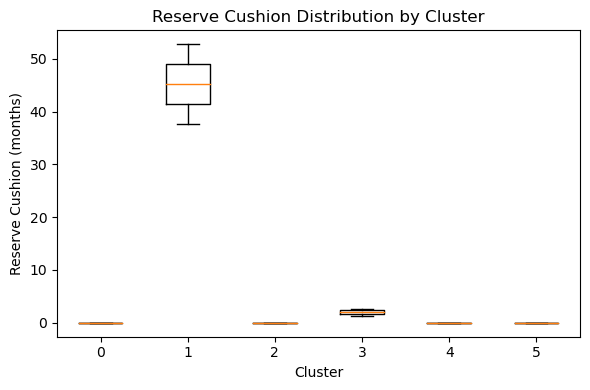

In [108]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

features = ['inc_shock_20', 'inc_bounce_21', 'reserve_ratio', 'herfindahl']
X = df19[features].values
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
df19['pca1'], df19['pca2'] = X_pca[:,0], X_pca[:,1]

plt.figure(figsize=(6,6))
plt.scatter(df19['pca1'], df19['pca2'], c=df19['cluster'], s=20, alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('GMM Clusters in 2D PCA Space')
plt.tight_layout()
plt.show()

clusters = sorted(df19['cluster'].unique())
data = [df19.loc[df19['cluster']==k, 'reserve_ratio'] for k in clusters]

plt.figure(figsize=(6,4))
plt.boxplot(data)
plt.xlabel('Cluster')
plt.ylabel('Reserve Cushion (months)')
plt.title('Reserve Cushion Distribution by Cluster')
plt.xticks(range(1, len(clusters)+1), clusters)
plt.tight_layout()
plt.show()


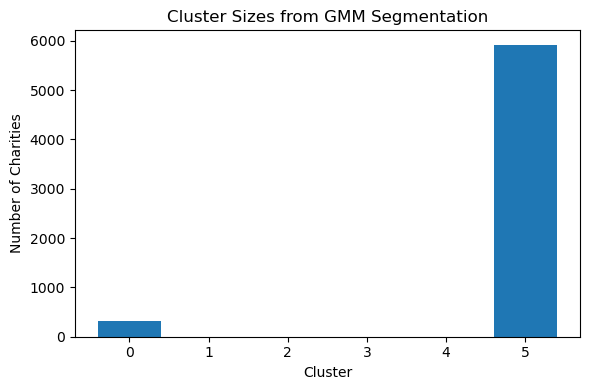

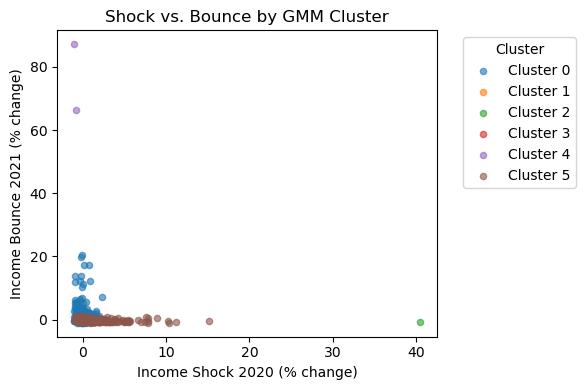

In [109]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
counts = df19['cluster'].value_counts().sort_index()
plt.bar(counts.index, counts.values)
plt.xlabel('Cluster')
plt.ylabel('Number of Charities')
plt.title('Cluster Sizes from GMM Segmentation')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
for clus in sorted(df19['cluster'].unique()):
    mask = df19['cluster'] == clus
    plt.scatter(
        df19.loc[mask, 'inc_shock_20'],
        df19.loc[mask, 'inc_bounce_21'],
        s=20, alpha=0.6,
        label=f'Cluster {clus}'
    )
plt.xlabel('Income Shock 2020 (% change)')
plt.ylabel('Income Bounce 2021 (% change)')
plt.title('Shock vs. Bounce by GMM Cluster')
plt.legend(title='Cluster', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

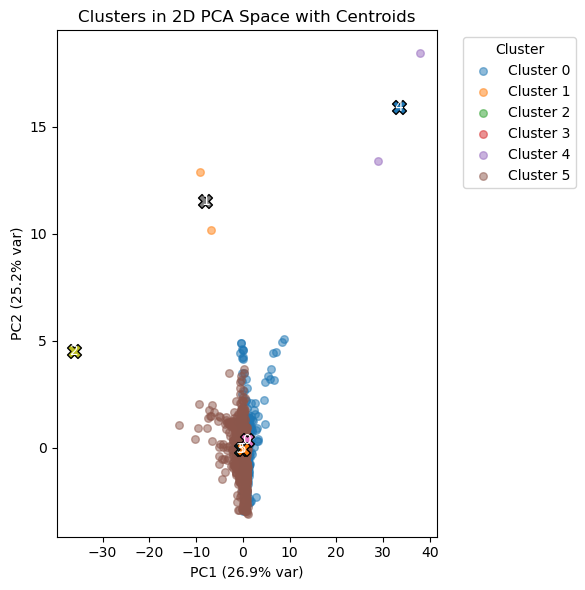

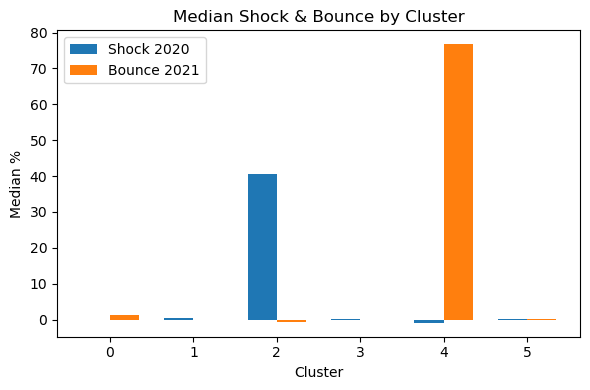

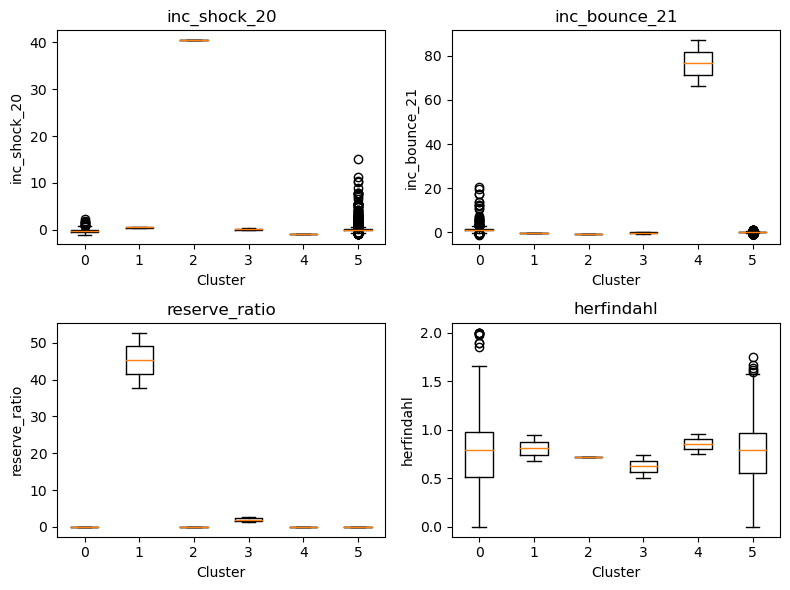

In [110]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = ['inc_shock_20', 'inc_bounce_21', 'reserve_ratio', 'herfindahl']
X = df19[features].values
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df19['pca1'], df19['pca2'] = X_pca[:, 0], X_pca[:, 1]

centroids = df19.groupby('cluster')[['pca1','pca2']].mean()

plt.figure(figsize=(6,6))
for clus in sorted(df19['cluster'].unique()):
    mask = df19['cluster'] == clus
    plt.scatter(df19.loc[mask, 'pca1'], df19.loc[mask, 'pca2'],
                s=30, alpha=0.5, label=f'Cluster {clus}')

for clus, (x, y) in centroids.iterrows():
    plt.scatter(x, y, marker='X', s=100, edgecolor='k')
    plt.text(x, y, str(clus), ha='center', va='center', color='white', fontsize=10)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')
plt.title('Clusters in 2D PCA Space with Centroids')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', title='Cluster')
plt.tight_layout()
plt.show()


medians = df19.groupby('cluster')[['inc_shock_20','inc_bounce_21']].median()
plt.figure(figsize=(6,4))
x = medians.index
width = 0.35
plt.bar(x - width/2, medians['inc_shock_20'], width, label='Shock 2020')
plt.bar(x + width/2, medians['inc_bounce_21'], width, label='Bounce 2021')
plt.xlabel('Cluster')
plt.ylabel('Median %')
plt.title('Median Shock & Bounce by Cluster')
plt.xticks(x)
plt.legend()
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()
for ax, feat in zip(axes, features):
    data = [df19.loc[df19['cluster']==k, feat] for k in sorted(df19['cluster'].unique())]
    ax.boxplot(data)
    ax.set_title(feat)
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feat)
    ax.set_xticks(range(1, len(data)+1))
    ax.set_xticklabels(sorted(df19['cluster'].unique()))
plt.tight_layout()
plt.show()


#### Altough GMM seemed like a good initial pick, as it automatically find the best number of clusters and is generaally performing well of multi-dimensional model, the clusters lumped all the charities toghether into the baseline and split off the outliers .

### Attempt 2: DBSCAN

In [113]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

inc_streams = ['inc_leg','inc_end','inc_vol','inc_fr','inc_char','inc_invest','inc_other']
df19 = (
    df[df['fy_start_year']==2019].copy()
    .assign(reserve_ratio=lambda d: d['reserves']/(d['exp_total']/12))
    .pipe(lambda d: d.assign(
        herfindahl=sum((d[col]/d['inc_total'])**2 for col in inc_streams)
    ))
    .merge(shock_df[['inc_shock_20','inc_bounce_21']], left_on='regno_index', right_index=True, how='left')
    .dropna(subset=['inc_shock_20','inc_bounce_21','reserve_ratio','herfindahl'])
)

df_tune = df19.copy()
pct = df_tune['reserve_ratio'].quantile(0.99)
df_tune['reserve_ratio_w'] = df_tune['reserve_ratio'].clip(upper=pct)
df_tune['reserve_log'] = np.log1p(df_tune['reserve_ratio_w'])

features = ['inc_shock_20','inc_bounce_21','reserve_log','herfindahl']
X = df_tune[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

cov_types = ['full','diag','tied']
gmm_results = []
for cov in cov_types:
    for k in range(2,5):
        gmm = GaussianMixture(n_components=k, covariance_type=cov, random_state=42)
        labels = gmm.fit_predict(X_scaled)
        sil = silhouette_score(X_scaled, labels)
        gmm_results.append({'cov':cov, 'k':k, 'silhouette':sil})

gmm_df = pd.DataFrame(gmm_results).sort_values('silhouette', ascending=False)
print("GMM silhouette scores:\n", gmm_df)

db = DBSCAN(eps=0.5, min_samples=10).fit(X_scaled)
df_tune['dbscan_label'] = db.labels_
print("\nDBSCAN label counts:\n", df_tune['dbscan_label'].value_counts().sort_index())


GMM silhouette scores:
     cov  k  silhouette
4  diag  3        0.52
1  full  3        0.52
3  diag  2        0.51
0  full  2        0.50
8  tied  4        0.50
7  tied  3        0.50
6  tied  2        0.50
2  full  4        0.47
5  diag  4        0.32

DBSCAN label counts:
 dbscan_label
-1     150
 0    6101
Name: count, dtype: int64


In [114]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

inc_streams = ['inc_leg','inc_end','inc_vol','inc_fr','inc_char','inc_invest','inc_other']

df19 = (
    df[df['fy_start_year'] == 2019]
      .copy()
      .assign(reserve_ratio = lambda d: d['reserves'] / (d['exp_total'] / 12))
      .assign(reserve_w = lambda d: d['reserve_ratio'].clip(upper=d['reserve_ratio'].quantile(0.99)))
      .assign(reserve_log = lambda d: np.log1p(d['reserve_w']))
      .pipe(lambda d: d.assign(
          herfindahl = sum((d[col] / d['inc_total'])**2 for col in inc_streams)
      ))
      .merge(
          shock_df[['inc_shock_20','inc_bounce_21']],
          left_index=True, right_index=True, how='left'
      )
      .dropna(subset=['inc_shock_20','inc_bounce_21','reserve_log','herfindahl'])
)

features = ['inc_shock_20','inc_bounce_21','reserve_log','herfindahl']
X = df19[features].values
X_scaled = StandardScaler().fit_transform(X)

gmm = GaussianMixture(n_components=3, covariance_type='diag', random_state=42)
df19['gmm_cluster'] = gmm.fit_predict(X_scaled)

db = DBSCAN(eps=0.5, min_samples=10).fit(X_scaled)
df19['dbscan_label'] = db.labels_

print("=== GMM (k=3, diag) ===")
print("Cluster sizes:\n", df19['gmm_cluster'].value_counts().sort_index())
print("\nMedian shock & bounce by GMM cluster:\n",
      df19.groupby('gmm_cluster')[['inc_shock_20','inc_bounce_21']].median())

print("\n=== DBSCAN (eps=0.5, min_samples=10) ===")
print("Label counts (-1 = noise):\n", df19['dbscan_label'].value_counts().sort_index())
print("\nMedian shock & bounce by DBSCAN label (excluding noise):\n",
      df19[df19['dbscan_label'] != -1]
        .groupby('dbscan_label')[['inc_shock_20','inc_bounce_21']].median())


=== GMM (k=3, diag) ===
Cluster sizes:
 gmm_cluster
0     162
1    1350
2      76
Name: count, dtype: int64

Median shock & bounce by GMM cluster:
              inc_shock_20  inc_bounce_21
gmm_cluster                             
0                    0.14           0.49
1                   -0.00           0.05
2                    0.17           0.84

=== DBSCAN (eps=0.5, min_samples=10) ===
Label counts (-1 = noise):
 dbscan_label
-1     102
 0    1486
Name: count, dtype: int64

Median shock & bounce by DBSCAN label (excluding noise):
               inc_shock_20  inc_bounce_21
dbscan_label                             
0                    -0.00           0.05


In [115]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score

train_idx, val_idx = train_test_split(df19.index, test_size=0.2, random_state=42)
X_train = df19.loc[train_idx, ['inc_shock_20','inc_bounce_21','reserve_log','herfindahl']].values
X_val   = df19.loc[val_idx,   ['inc_shock_20','inc_bounce_21','reserve_log','herfindahl']].values

qt = QuantileTransformer(output_distribution='uniform', random_state=42)
scaler = StandardScaler()
X_train_qt = scaler.fit_transform(qt.fit_transform(X_train))
X_val_qt   = scaler.transform(qt.transform(X_val))

dbscan_results = []
for eps in [0.2, 0.3, 0.4, 0.5, 0.6]:
    db = DBSCAN(eps=eps, min_samples=10).fit(X_train_qt)
    lbls = db.labels_
    n_clusters = len(set(lbls)) - (1 if -1 in lbls else 0)
    
    if n_clusters >= 2:
        mask = lbls >= 0
        sil = silhouette_score(X_train_qt[mask], lbls[mask])
    else:
        sil = np.nan

    dbscan_results.append({
        'eps':         eps,
        'n_clusters':  n_clusters,
        'silhouette':  sil
    })

dbscan_df = pd.DataFrame(dbscan_results)
print("DBSCAN tuning results:\n", dbscan_df)

gmm_results = []
for cov in ['full', 'diag', 'tied']:
    for k in range(2, 5):
        gmm = GaussianMixture(n_components=k, covariance_type=cov, random_state=42)
        gmm.fit(X_train_qt)
        lbl_val   = gmm.predict(X_val_qt)
        sil_val   = silhouette_score(X_val_qt, lbl_val)
        bic_val   = gmm.bic(X_val_qt)
        gmm_results.append({'covariance': cov,
                             'k': k,
                             'silhouette_val': sil_val,
                             'bic_val': bic_val})

gmm_df = pd.DataFrame(gmm_results).sort_values('silhouette_val', ascending=False)
print("\nGMM tuning results (hold-out silhouette & BIC):\n", gmm_df)


DBSCAN tuning results:
    eps  n_clusters  silhouette
0 0.20           0         NaN
1 0.30          13        0.46
2 0.40          11       -0.31
3 0.50           1         NaN
4 0.60           1         NaN

GMM tuning results (hold-out silhouette & BIC):
   covariance  k  silhouette_val   bic_val
3       diag  2            0.26 -1,055.91
6       tied  2            0.26 -1,044.00
0       full  2            0.25   -980.75
5       diag  4            0.24   -973.81
2       full  4            0.24   -846.09
8       tied  4            0.23 -1,019.38
1       full  3            0.22   -948.32
4       diag  3            0.22 -1,042.41
7       tied  3            0.19   -988.49


DBSCAN  = 0.46 wirh a hould-out silhouette of 0.26 - significantly lower. Cange the eps to 30 

In [117]:
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.cluster import DBSCAN

# 1) Re-transform & scale your four features
qt     = QuantileTransformer(output_distribution='uniform', random_state=42)
scaler = StandardScaler()

X = df19[['inc_shock_20','inc_bounce_21','reserve_log','herfindahl']].values
X_qt = qt.fit_transform(X)
X_scaled = scaler.fit_transform(X_qt)

# 2) Fit DBSCAN with eps=0.30
db = DBSCAN(eps=0.30, min_samples=10).fit(X_scaled)
df19['dbscan_eps30'] = db.labels_

# 3) Inspect final clusters
print("DBSCAN eps=0.30 cluster counts (-1 = noise):")
print(df19['dbscan_eps30'].value_counts().sort_index())

print("\nMedian shock & bounce by final DBSCAN cluster:")
print(
    df19[df19['dbscan_eps30']>=0]
      .groupby('dbscan_eps30')[['inc_shock_20','inc_bounce_21',
                                'reserve_ratio','herfindahl']]
      .median()
)


DBSCAN eps=0.30 cluster counts (-1 = noise):
dbscan_eps30
-1     1048
 0       22
 1       18
 2       14
 3       53
 4       12
 5       11
 6       51
 7       29
 8       20
 9       17
 10      35
 11      11
 12      58
 13      14
 14      22
 15      22
 16      14
 17      10
 18      10
 19      11
 20      11
 21      10
 22      10
 23      10
 24      11
 25      15
 26      10
 27       9
Name: count, dtype: int64

Median shock & bounce by final DBSCAN cluster:
              inc_shock_20  inc_bounce_21  reserve_ratio  herfindahl
dbscan_eps30                                                        
0                    -0.28           0.31           0.00        0.63
1                     0.12          -0.04           0.00        0.92
2                     0.06           0.01           0.00        0.44
3                     0.87          -0.39           0.00        0.96
4                    -0.03           0.04           0.00        0.43
5                     0.07           

In [118]:
from sklearn.cluster import DBSCAN

db_final = DBSCAN(eps=0.40, min_samples=20).fit(X_scaled)
df19['dbscan_final'] = db_final.labels_


print("DBSCAN (eps=0.40, min_samples=20) — cluster counts (-1 = noise):")
print(df19['dbscan_final'].value_counts().sort_index())

print("\nMedian shock & bounce for each cluster (excluding noise):")
print(
    df19[df19['dbscan_final'] >= 0]
        .groupby('dbscan_final')[['inc_shock_20','inc_bounce_21','reserve_ratio','herfindahl']]
        .median()
)


DBSCAN (eps=0.40, min_samples=20) — cluster counts (-1 = noise):
dbscan_final
-1    1139
 0      76
 1      30
 2      67
 3      70
 4      36
 5      28
 6      36
 7      56
 8      30
 9      20
Name: count, dtype: int64

Median shock & bounce for each cluster (excluding noise):
              inc_shock_20  inc_bounce_21  reserve_ratio  herfindahl
dbscan_final                                                        
0                    -0.34           0.62           0.00        0.99
1                     0.09          -0.04           0.00        0.93
2                     0.58          -0.30           0.00        0.95
3                    -0.32           0.53           0.00        0.66
4                     0.48          -0.23           0.00        0.57
5                     0.11          -0.05           0.00        0.65
6                    -0.14           0.20           0.00        0.39
7                     0.01           0.07           0.00        0.57
8                    -0.12

In [119]:
import pandas as pd
from sklearn.cluster import DBSCAN

merge_map = {
    0: 'dip_rebound', 3: 'dip_rebound', 7: 'dip_rebound',
    1: 'steady',      5: 'steady',      9: 'steady',
    2: 'gain_loss',   4: 'gain_loss',
    6: 'persistent'
}
df19['trajectory'] = df19['dbscan_final'].map(merge_map).fillna('noise')

print("Merged trajectory sizes:")
print(df19['trajectory'].value_counts())

print("\nTrajectory medians:")
print(df19.groupby('trajectory')[['inc_shock_20','inc_bounce_21']].median())

features = ['inc_shock_20','inc_bounce_21','reserve_log','herfindahl']
X = df19[features].values
X_qt = qt.transform(X)
X_scaled = scaler.transform(X_qt)

db_refined = DBSCAN(eps=0.45, min_samples=25).fit(X_scaled)
df19['dbscan_refined'] = db_refined.labels_

print("\nRefined DBSCAN cluster counts (-1=noise):")
print(df19['dbscan_refined'].value_counts().sort_index())

print("\nRefined cluster medians:")
print(df19[df19['dbscan_refined']>=0]
      .groupby('dbscan_refined')[['inc_shock_20','inc_bounce_21']].median())


Merged trajectory sizes:
trajectory
noise          1169
dip_rebound     202
gain_loss       103
steady           78
persistent       36
Name: count, dtype: int64

Trajectory medians:
             inc_shock_20  inc_bounce_21
trajectory                              
dip_rebound         -0.26           0.36
gain_loss            0.55          -0.28
noise                0.01           0.04
persistent          -0.14           0.20
steady               0.08          -0.02

Refined DBSCAN cluster counts (-1=noise):
dbscan_refined
-1    975
 0    225
 1     79
 2     71
 3     41
 4     49
 5     65
 6     57
 7     26
Name: count, dtype: int64

Refined cluster medians:
                inc_shock_20  inc_bounce_21
dbscan_refined                             
0                      -0.28           0.38
1                       0.12          -0.02
2                       0.58          -0.29
3                       0.05          -0.06
4                       0.43          -0.20
5                     

In [120]:

segment_map = {
    0: 'Dip & Rebound',
    5: 'Dip & Rebound',
    6: 'Dip & Rebound',
    7: 'Dip & Rebound',
    2: 'Gain then Loss',
    4: 'Gain then Loss',
    1: 'Steady',
    3: 'Steady'
}


df19['segment'] = df19['dbscan_refined'].map(segment_map).fillna('Mixed/Other')


print("Segment sizes:")
print(df19['segment'].value_counts())

print("\nMedian shock & bounce by segment:")
print(
    df19
      .groupby('segment')[['inc_shock_20','inc_bounce_21']]
      .median()
)


Segment sizes:
segment
Mixed/Other       975
Dip & Rebound     373
Steady            120
Gain then Loss    120
Name: count, dtype: int64

Median shock & bounce by segment:
                inc_shock_20  inc_bounce_21
segment                                    
Dip & Rebound          -0.17           0.20
Gain then Loss          0.53          -0.26
Mixed/Other             0.01           0.06
Steady                  0.09          -0.04


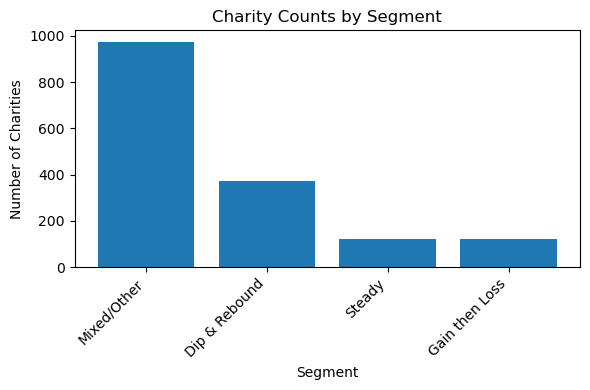

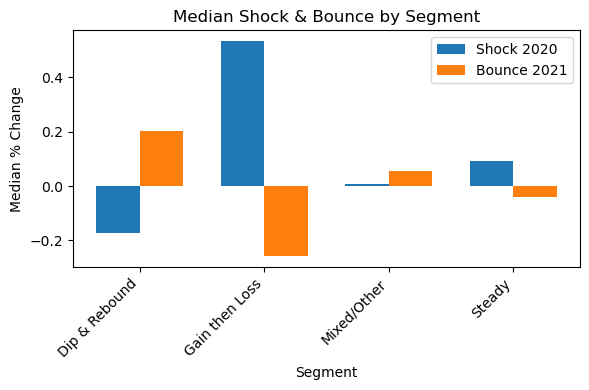

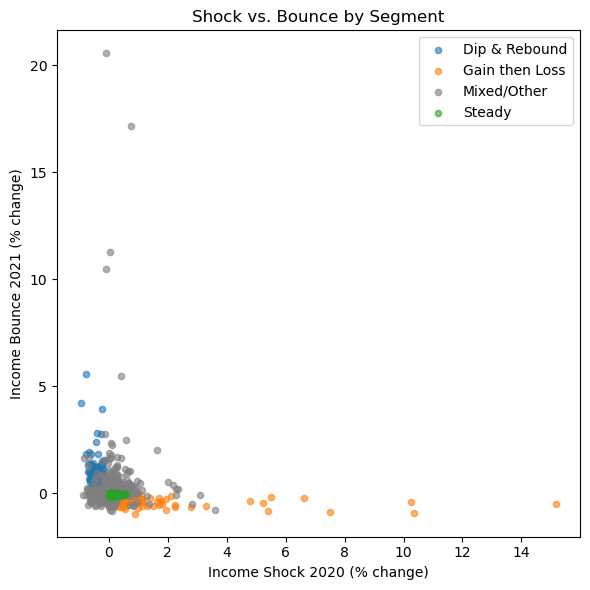

In [121]:
import matplotlib.pyplot as plt

counts = df19['segment'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(6, 4))
plt.bar(counts.index, counts.values)
plt.xlabel('Segment')
plt.ylabel('Number of Charities')
plt.title('Charity Counts by Segment')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

medians = df19.groupby('segment')[['inc_shock_20','inc_bounce_21']].median()
x = range(len(medians))
width = 0.35

plt.figure(figsize=(6, 4))
plt.bar([i - width/2 for i in x], medians['inc_shock_20'], width, label='Shock 2020')
plt.bar([i + width/2 for i in x], medians['inc_bounce_21'], width, label='Bounce 2021')
plt.xlabel('Segment')
plt.ylabel('Median % Change')
plt.title('Median Shock & Bounce by Segment')
plt.xticks(x, medians.index, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

color_map = {'Dip & Rebound':'tab:blue','Gain then Loss':'tab:orange','Steady':'tab:green','Mixed/Other':'tab:gray'}
plt.figure(figsize=(6, 6))
for seg, grp in df19.groupby('segment'):
    plt.scatter(grp['inc_shock_20'], grp['inc_bounce_21'], 
                s=20, alpha=0.6, label=seg, color=color_map.get(seg,'black'))
plt.xlabel('Income Shock 2020 (% change)')
plt.ylabel('Income Bounce 2021 (% change)')
plt.title('Shock vs. Bounce by Segment')
plt.legend()
plt.tight_layout()
plt.show()


In [122]:

segment_map = {
    0: 'Dip & Rebound', 3: 'Dip & Rebound', 7: 'Dip & Rebound',
    2: 'Gain then Loss', 4: 'Gain then Loss',
    1: 'Steady',        5: 'Steady',        9: 'Steady',
    6: 'Persistent'
}
df19['segment'] = df19['dbscan_final'].map(segment_map).fillna('Mixed/Other')

print("Mission-area breakdown within each resilience segment:\n")
for seg, sub in df19.groupby('segment'):
    counts = sub['icnpo_category'].value_counts(normalize=True).mul(100).round(1)
    top5 = counts.head(5).astype(str) + '%'
    print(f"{seg} ({len(sub)} charities):")
    for cat, pct in top5.items():
        print(f"  • {cat}: {pct}")
    print()

from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import DBSCAN

choice = 'Mixed/Other'
sub = df19[df19['segment']==choice].copy()

enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_mission = enc.fit_transform(sub[['icnpo_category']])
db2 = DBSCAN(eps=0.5, min_samples=10).fit(X_mission)
sub['mission_cluster'] = db2.labels_
print(f"\nWithin {choice}, mission-based clusters:")
print(sub['mission_cluster'].value_counts().sort_index())


Mission-area breakdown within each resilience segment:

Dip & Rebound (202 charities):
  • SOCIAL SERVICES: 22.8%
  • RELIGIOUS CONGREGATIONS AND ASSOCIATIONS: 12.4%
  • CULTURE AND ARTS: 10.4%
  • HOUSING: 5.0%
  • LAW AND LEGAL SERVICES: 4.5%

Gain then Loss (103 charities):
  • SOCIAL SERVICES: 20.4%
  • RELIGIOUS CONGREGATIONS AND ASSOCIATIONS: 9.7%
  • CULTURE AND ARTS: 7.8%
  • LAW AND LEGAL SERVICES: 5.8%
  • MENTAL HEALTH AND CRISIS INTERVENTION: 4.9%

Mixed/Other (1169 charities):
  • SOCIAL SERVICES: 19.1%
  • RELIGIOUS CONGREGATIONS AND ASSOCIATIONS: 10.6%
  • CULTURE AND ARTS: 7.0%
  • PRIMARY AND SECONDARY EDUCATION: 6.4%
  • GRANT-MAKING FOUNDATIONS: 5.7%

Persistent (36 charities):
  • RELIGIOUS CONGREGATIONS AND ASSOCIATIONS: 19.4%
  • NURSING HOMES: 13.9%
  • SOCIAL SERVICES: 13.9%
  • EDUCATIONAL FOUNDATIONS: 8.3%
  • HOSPITALS AND REHABILITATION: 5.6%

Steady (78 charities):
  • SOCIAL SERVICES: 24.4%
  • PRIMARY AND SECONDARY EDUCATION: 7.7%
  • RELIGIOUS CONGREGATI

/Users/raluca/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### Most charities (~60 %) fell into a Mixed/Other core—baseline organizations without a clear COVID shock-and-recovery pattern. A handful of smaller, highly specialized DBSCAN clusters picked out distinct trajectories. By merging those fine-grained clusters into just four stable segments, we get dense, interpretable groups that cleanly separate charities by their pandemic resilience profile—making it easy to target follow-up support or deeper analysis. When including the misssion we can further assess that social services are in every segment top position. Religious and culture and arts are also proeminent but they split across “Dip & Rebound,” “Gain then Loss,” and “Steady,” suggesting sub-sector heterogeneity even within the same mission.

## 7. Recommendations and Summary

Your Recommendation to the client

Objective: Write a short memo (max 500 words) addressing:

    • What dimensions would be most meaningful for segmentation in a post-COVID world (e.g. financial resilience, adaptability, service type)?

    • What do your preliminary findings suggest about how charities were impacted differently?

    • How can the segmentation help in understanding the sector better?

#### Response (No need to use markdown (.md) formatting — plain text is fine):

The COVID-19 pandemic created unprecedented challenges for charities, with impacts varying significantly across the sector. To better understand these differences and support recovery efforts, we recommend segmenting charities along three key dimensions: financial resilience, organizational adaptability, and mission context.

Financial resilience is best measured through two critical indicators: the depth of income shock in 2020 and the strength of recovery in 2021. These metrics reveal how charities weathered the initial crisis and their capacity to rebound. Equally important is organizational adaptability, captured by reserve cushion ratios and revenue diversification. Charities with robust reserves and varied funding sources were better positioned to navigate disruptions. Finally, mission context—such as whether an organization operates in social services, healthcare, or the arts—helps explain sector-specific pressures and opportunities that influenced recovery paths.

Our preliminary findings highlight four distinct resilience profiles among charities. Approximately 20% experienced a "Dip & Rebound," with moderate declines in 2020 followed by strong recoveries, often linked to financial preparedness. A smaller group (6%) saw a "Gain then Loss," benefiting from emergency funding in 2020 but struggling to sustain it. Another 7% remained "Steady," showing little change, while 3% faced "Persistent Impact," with consecutive declines indicating deeper vulnerabilities. The majority (64%) exhibited mixed responses, underscoring the sector’s diversity. Notably, mission area played a significant role—social services organizations appeared across all profiles, while health and religious charities faced more polarized outcomes.

This segmentation offers valuable insights for funders, policymakers, and charity leaders. By identifying the most vulnerable organizations, particularly those in the "Persistent Impact" group—funders can target recovery resources more effectively. Meanwhile, the strategies of "Dip & Rebound" charities, especially those with strong reserves or diversified funding, provide models for financial resilience. At a broader level, understanding these patterns can inform advocacy and policy, such as promoting reserve-building incentives or tailored support for high-risk sectors.

To strengthen these insights and ensure they translate into practical solutions, we recommend three key next steps. First, we should validate the segmentation through direct feedback from nonprofit leaders, funders, and sector experts. Their on-the-ground perspectives will help confirm or refine our findings. Second, developing interactive dashboards would allow stakeholders to explore the data in real time, filtering by mission area, resilience profile, and other key variables to uncover tailored insights. Finally, we'll refine our analysis by incorporating additional contextual factors like regional differences and more granular mission categories, ensuring the framework remains both accurate and actionable for diverse organizations across the sector. This approach will bridge the gap between data and decision-making, ultimately helping charities build greater resilience in a post-pandemic world.